# TLS-COVID19 Dataset

## Collect data

### Requirements

In [1]:
# Selenium (required to collect CNN news)
!apt update
!apt install chromium-chromedriver

!pip install selenium

# Date handling
!pip install dateparser

'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [2]:
# Packages from Python standard library
import os
import time
import re
import json
import html
from datetime import datetime
from pathlib import Path
from urllib.parse import urlencode

# Third-party packages
import requests
import dateparser
from bs4 import BeautifulSoup
from selenium import webdriver

### Sources

In [3]:
# The root directory where the datasets will be placed
DATA_DIR = 'data/'
# Create dir if does not exist
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# Used in requests
HEADERS = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'}

# Functions used across all liveblog collectors

def clean_html(text):
  text = html.unescape(text)
  tags_regex = re.compile('<.*?>')
  text = re.sub(tags_regex, '', str(text))
  return text

def pre_proc(text):
  text = clean_html(text)
  # Some news contain special characters like \r, \t, \n
  text = ' '.join(text.split())
  return text

# Returns date as string in format yyyy-mm-dd hh:mm
def format_date(date_str):
  return dateparser.parse(date_str).strftime('%Y-%m-%d %H:%M')

def write_json(file_path, json_data):
  print('Writing ' + file_path)
  with open(file_path, 'w', encoding='utf8') as fp:
      json.dump(json_data, fp, ensure_ascii=False, indent=4)

# Store data collection information as the number of liveblogs, number of news, number of key moments and first and last date
collection_stats = {}

def get_source_stats(num_lbs, num_news, num_kms, first_date, last_date):
  stats = {
      'num_lbs': num_lbs,
      'num_news': num_news,
      'num_kms': num_kms,
      'first_date': first_date,
      'last_date': last_date
  }
  return stats

#### Publico

In [4]:
# Place publico data under data/publico
DATA_DIR_PUBLICO = os.path.join(DATA_DIR, 'publico/')
# Create dir if does not exist
Path(DATA_DIR_PUBLICO).mkdir(parents=True, exist_ok=True)


# Traverse all liveblog api entries and collect their ids, dates and urls
# Returns a list of dictionaries. Each dict contains the date, id and url of a liveblog
def get_blogs_publico():

    print('===== Collecting Publico liveblogs =====')

    url_lbs_listing = 'https://www.publico.pt/api/list/coronavirus-ao-minuto'
    payload = {'page': 0}

    list_blogs = []
    while True:

        r = requests.get(url_lbs_listing, headers=HEADERS, params=payload)
        response_json = r.json()

        # Exit if there are no more entries
        if len(response_json) < 1:
            break

        # For each liveblog collect its date, id and url
        for lb in response_json:
            lb_dict = {}
            lb_dict['date'] = format_date(lb['data']).split()[0]
            lb_dict['id'] = lb['id']
            lb_dict['url'] = lb['shareUrl']
            print(lb_dict['url'])
            list_blogs.append(lb_dict)

        payload['page'] += 1

    # 287 lbs as of 18/12
    print('# lbs:', len(list_blogs))
    print()

    return list_blogs

# Use the liveblog ids to request the liveblog api endpoint and collect the news under them
# Returns a list of dicts of news and a list of dicts of keymoments. Each dict contains the title, text, date, url and keymoment flag of the news
def get_news_publico():

    lbs = get_blogs_publico()

    print('===== Collecting Publico liveblogs news =====')

    url_liveblog_api = 'https://api.publico.pt/liveblog/'

    list_news, list_kms = [], []
    for i, lb in enumerate(lbs):
        lb_url = lb['url']

        print(str(i+1) + '/' + str(len(lbs)))
        print(lb_url)

        lb_api_url = url_liveblog_api + str(lb['id']) 
        r = requests.get(lb_api_url, headers=HEADERS)
        response_json = r.json()

        # For each liveblog article collect its title, text, date and url
        list_news_lb, list_kms_lb = [], []
        for article in response_json:
            news = {}
            news['title'] = clean_html(article['titulo'])
            news['text'] = pre_proc(article['texto'])
            news['date'] = format_date(article['data'])
            news['is_km'] = str(article['isDestaque'])
            news['url'] = lb_url + '#' + str(article['id'])
            list_news_lb.append(news)

            # If article is key moment (isDestaque) append it to key moments list also
            if article['isDestaque'] == True:
                list_kms_lb.append(news)

        list_news.extend(list_news_lb)
        list_kms.extend(list_kms_lb)

        print('# news:', len(list_news_lb))
        print('# kms:', len(list_kms_lb))
        print()
    
    # Sort news by descending date
    list_news.sort(key=lambda item:item['date'], reverse=True)
    list_kms.sort(key=lambda item:item['date'], reverse=True)

    # Generate and store stats of the collection
    source_stats = get_source_stats(len(lbs), len(list_news), len(list_kms), list_news[-1]['date'].split()[0], list_news[0]['date'].split()[0])
    collection_stats['publico'] = source_stats

    print('Stats: ')
    for k, v in source_stats.items():
      print(k + ': ' + str(v))
    print()
    
    return list_news, list_kms

news_publico, kms_publico = get_news_publico()

# Creates a json file with the liveblog news under data/publico/
publico_news_path = os.path.join(DATA_DIR_PUBLICO, 'news_publico.json')
write_json(publico_news_path, news_publico)

# Creates a json file with the keymoments news under data/publico/
publico_kms_path = os.path.join(DATA_DIR_PUBLICO, 'kms_publico.json')
write_json(publico_kms_path, kms_publico)

===== Collecting Publico liveblogs =====
https://www.publico.pt/2023/07/19/mundo/noticia/duas-mil-pessoas-retiradas-crimeia-apos-incendio-explosoes-2057362
https://www.publico.pt/2023/07/16/mundo/noticia/soldados-grupo-wagner-comecam-chegar-bielorrussia-2057026
https://www.publico.pt/2023/07/15/mundo/noticia/criticas-soldados-russos-chefias-vao-continuar-aumentar-preve-reino-unido-2056968
https://www.publico.pt/2023/07/14/mundo/noticia/biden-moscovo-ja-perdeu-guerra-russia-prende-altas-patentes-militares-2056834
https://www.publico.pt/2023/07/13/mundo/noticia/russia-considera-cedencia-cacas-f16-ucrania-ameaca-nuclear-2056673
https://www.publico.pt/2023/06/13/mundo/noticia/ataque-russo-dimensao-faz-menos-seis-mortos-ucrania-2053111
https://www.publico.pt/2023/06/07/mundo/noticia/destruicao-barragem-ucrania-coloca-42-mil-pessoas-risco-esperamse-mortes-eua-2052503
https://www.publico.pt/2023/06/04/mundo/noticia/ataque-dnipro-mata-crianca-dois-anos-ha-22-pessoas-feridas-2052158
https://www

https://www.publico.pt/2022/03/24/mundo/noticia/numero-mortes-forcas-russas-chegar-15-mil-bruxelas-acolhe-cimeiras-nato-g7-ue-1999972
https://www.publico.pt/2022/03/22/mundo/noticia/biden-acusa-putin-querer-usar-armas-quimicas-ucrania-dez-mil-soldados-russos-mortos-conflito-1999649
https://www.publico.pt/2022/03/19/mundo/noticia/zelenskii-pede-negociacoes-evitem-perdas-varias-geracoes-russia-tera-usado-misseis-hipersonicos-1999391
https://www.publico.pt/2022/03/18/mundo/noticia/biden-avisa-xi-jinping-custos-caso-ajuda-chinesa-russia-explosoes-lviv-madrugada-1999232
https://www.publico.pt/2022/03/13/mundo/noticia/russia-ataca-base-25-quilometros-territorio-nato-alerta-possibilidade-uso-armas-quimicas-1998606
https://www.publico.pt/2022/03/12/mundo/noticia/russia-intensifica-ataques-arredores-kiev-1998529
https://www.publico.pt/2022/03/07/mundo/noticia/russia-bombardeia-cidade-mykolaiv-ronda-negociacoes-marcada-hoje-1997828
https://www.publico.pt/2022/03/01/mundo/noticia/russia-envia-ref

https://www.publico.pt/2021/08/20/sociedade/noticia/covid19-governo-anuncia-hoje-portugal-passo-direccao-normalidade-1974690
https://www.publico.pt/2021/08/19/sociedade/noticia/ja-arrancou-autoagendamento-jovens-12-17-anos-1974567
https://www.publico.pt/2021/08/18/sociedade/noticia/estados-unidos-franca-atingem-pico-mortes-ultimos-meses-1974457
https://www.publico.pt/2021/08/17/sociedade/noticia/estados-unidos-planeiam-administrar-terceira-dose-partir-setembro-1974322
https://www.publico.pt/2021/08/16/sociedade/noticia/covid19-japao-australia-prolongam-confinamentos-combater-aumento-casos-1974204
https://www.publico.pt/2021/08/15/sociedade/noticia/anticorpos-imunodeprimidos-crescem-43-apos-terceira-dose-vacina-pfizer-1974155
https://www.publico.pt/2021/08/14/sociedade/noticia/covid19-modalidade-casa-aberta-ja-disponivel-maiores-16-anos-1974102
https://www.publico.pt/2021/08/13/sociedade/noticia/covid19-estados-unidos-autorizam-terceira-dose-vacinas-imunodeprimidos-1973969
https://www.p

https://www.publico.pt/2021/06/11/sociedade/noticia/covid19-nova-fase-desconfinamento-ja-comecou-restauracao-comercio-voltam-horario-normal-1966071
https://www.publico.pt/2021/06/10/sociedade/noticia/eua-vao-doar-500-milhoes-vacinas-covid19-paises-pobres-1965964
https://www.publico.pt/2021/06/09/sociedade/noticia/covid19-malasia-esgota-capacidade-cuidados-intensivos-farmaceutico-preso-eua-comprometer-vacinas-1965820
https://www.publico.pt/2021/06/08/sociedade/noticia/espanha-recua-exigencia-teste-fronteiras-terrestres-lapso-santos-silva-1965655
https://www.publico.pt/2021/06/07/sociedade/noticia/covid19-espanha-reabre-fronteiras-turistas-vacinados-1965512
https://www.publico.pt/2021/06/06/sociedade/noticia/covid19-eua-estao-optimistas-negociacoes-levantamento-patentes-vacinas-1965452
https://www.publico.pt/2021/06/05/sociedade/noticia/covid19-cdc-pede-adolescentes-norteamericanos-vacinem-aumento-hospitalizacoes-1965385
https://www.publico.pt/2021/06/04/sociedade/noticia/covid19-anthony

https://www.publico.pt/2021/04/02/sociedade/noticia/covid19-autotestes-chegam-sextafeira-500-farmacias-portuguesas-1956962
https://www.publico.pt/2021/04/01/sociedade/noticia/covid19-governo-revela-hoje-proximos-passos-desconfinamento-1956787
https://www.publico.pt/2021/03/31/sociedade/noticia/covid19-merkel-macron-putin-conversas-possivel-autorizacao-producao-vacina-sputnik-v-uniao-europeia-1956602
https://www.publico.pt/2021/03/30/sociedade/noticia/covid19-canada-suspende-vacina-astrazeneca-menores-55-anos-questoes-seguranca-1956453
https://www.publico.pt/2021/03/29/sociedade/noticia/oms-sarscov2-devera-passado-morcegos-humanos-atraves-animal-1956309
https://www.publico.pt/2021/03/28/sociedade/noticia/vacinacao-profissionais-escolas-continua-27-mil-pessoas-serem-vacinadas-sabado-1956242
https://www.publico.pt/2021/03/27/sociedade/noticia/covid19-vacinacao-professores-funcionarios-preescolar-1-ciclo-arranca-sabado-1956182
https://www.publico.pt/2021/03/26/sociedade/noticia/gnr-psp-est

https://www.publico.pt/2021/01/22/sociedade/noticia/escolas-fechadas-partir-hoje-circulacao-proibida-concelhos-ate-segunda-1947441
https://www.publico.pt/2021/01/21/sociedade/noticia/uniao-europeia-voltar-fechar-fronteiras-travar-propagacao-variantes-virus-1947291
https://www.publico.pt/2021/01/20/sociedade/noticia/novas-restricoes-ja-estao-vigor-variante-britanica-virus-detectada-60-paises-1947097
https://www.publico.pt/2021/01/19/sociedade/noticia/covid19-biden-reverte-decisao-trump-nao-levanta-restricoes-viagens-europa-brasil-1946925
https://www.publico.pt/2021/01/18/sociedade/noticia/covid19-populacao-vacinada-australia-manter-fronteiras-fechadas-2021-1946760
https://www.publico.pt/2021/01/17/sociedade/noticia/covid19-profissionais-saude-comecam-receber-segunda-dose-vacina-domingo-1946670
https://www.publico.pt/2021/01/16/sociedade/noticia/mundo-ultrapassa-dois-milhoes-mortes-covid19-oms-rejeita-passaporte-vacinados-1946598
https://www.publico.pt/2021/01/15/sociedade/noticia/portug

https://www.publico.pt/2020/11/13/mundo/noticia/covid19-mundo-bate-recorde-novos-casos-graca-freitas-avisa-vacina-gripe-nao-chegara-1939046
https://www.publico.pt/2020/11/12/sociedade/noticia/covid19-ensaios-vacina-coronavac-retomados-brasil-italia-ultrapassa-milhao-casos-1938887
https://www.publico.pt/2020/11/11/mundo/noticia/covid19-china-acredita-evitar-segunda-vaga-inverno-1938736
https://www.publico.pt/2020/11/10/mundo/noticia/covid19-brasil-suspende-ensaios-clinicos-vacina-coronavac-apos-incidente-grave-1938588
https://www.publico.pt/2020/11/09/mundo/noticia/portugal-entrou-estado-emergencia-eua-aproximamse-dez-milhoes-casos-1938445
https://www.publico.pt/2020/11/08/sociedade/noticia/covid19-portugal-restricoes-circulacao-proximos-dois-finsdesemana-1938374
https://www.publico.pt/2020/11/07/sociedade/noticia/covid19-governo-reunese-hoje-concretizar-medidas-estado-emergencia-1938304
https://www.publico.pt/2020/11/06/sociedade/noticia/covid19-oms-alerta-explosao-casos-europa-1938154

https://www.publico.pt/2020/09/04/sociedade/noticia/avante-festa-pcp-abre-hoje-portoes-16563-pessoas-1930343
https://www.publico.pt/2020/09/03/sociedade/noticia/alemanha-belgica-alargam-restricoes-espanha-7-mil-profissionais-saude-ja-morreram-durante-pandemia-1930176
https://www.publico.pt/2020/09/02/sociedade/noticia/governo-brasileiro-descarta-vacinacao-obrigatoria-covid19-1930018
https://www.publico.pt/2020/09/01/mundo/noticia/covid19-casos-franca-aumentam-quase-50-agosto-1929908
https://www.publico.pt/2020/08/31/mundo/noticia/covid19-rio-exige-governo-divulgue-parecer-dgs-festa-avante-1929774
https://www.publico.pt/2020/08/30/sociedade/noticia/india-maior-aumento-diario-mundial-covid19-1929729
https://www.publico.pt/2020/08/29/sociedade/noticia/escolas-podem-reabrir-teletrabalho-continuar-defende-centro-europeu-prevencao-controlo-doencas-1929686
https://www.publico.pt/2020/08/28/mundo/noticia/india-regista-77266-novos-casos-segundo-aumento-diario-alto-mundo-1929555
https://www.publ

https://www.publico.pt/2020/06/25/sociedade/noticia/covid19-milhao-novos-casos-semana-mundo-surtos-torres-vedras-grandola-somam-quase-trinta-novos-infectados-morto-1921831
https://www.publico.pt/2020/06/24/sociedade/noticia/especialistas-norteamericanos-notam-aumento-inquietante-afirmam-virus-pos-eua-joelhos-1921696
https://www.publico.pt/2020/06/23/sociedade/noticia/declaracao-queda-rendimentos-entregue-partir-hoje-ha-nove-milhoes-infectados-mundo-1921540
https://www.publico.pt/2020/06/22/sociedade/noticia/costa-reune-hoje-autarcas-concelhos-lisboa-afectados-1921415
https://www.publico.pt/2020/06/21/sociedade/noticia/espanha-reabre-fronteiras-paises-espaco-schengen-1921363
https://www.publico.pt/2020/06/20/sociedade/noticia/marcelo-portugal-decide-publico-fase-final-champions-1921301
https://www.publico.pt/2020/06/19/sociedade/noticia/covid19-china-surto-pequim-vem-europa-festa-lagos-infecta-69-pessoas-1921131
https://www.publico.pt/2020/06/18/sociedade/noticia/covid19-novo-surto-pequ

https://www.publico.pt/2020/04/16/sociedade/noticia/trump-pico-atingido-eua-registaram-2569-mortes-novo-maximo-diario-1912545
https://www.publico.pt/2020/04/15/sociedade/noticia/covid19-eua-registam-maior-numero-mortes-dia-sao-2200-1912339
https://www.publico.pt/2020/04/14/sociedade/noticia/terceiro-periodo-escolar-arranca-hoje-distancia-eua-registadas-1500-mortes-ultimas-24-horas-1912191
https://www.publico.pt/2020/04/13/sociedade/noticia/covid19-eua-registam-1500-mortes-ultimas-24-horas-espanha-volta-gradualmente-trabalho-1912038
https://www.publico.pt/2020/04/12/sociedade/noticia/vacina-limitar-maximo-possivel-contacto-idosos-von-der-leyen-1911969
https://www.publico.pt/2020/04/11/sociedade/noticia/eua-2000-mortes-so-dia-retorno-normalidade-previsto-novembro-1911906
https://www.publico.pt/2020/04/10/sociedade/noticia/eua-registam-1783-mortes-24-horas-china-42-novos-casos-1911816
https://www.publico.pt/2020/04/09/sociedade/noticia/covid19-ate-segundafeira-nao-sair-concelho-residencia

# news: 32
# kms: 8

30/672
https://www.publico.pt/2023/04/16/mundo/noticia/combates-sangrentos-precedentes-bakhmut-ucrania-2046274
# news: 17
# kms: 4

31/672
https://www.publico.pt/2023/04/15/mundo/noticia/estados-unidos-parar-encorajar-guerra-ucrania-lula-silva-2046215
# news: 19
# kms: 3

32/672
https://www.publico.pt/2023/04/12/mundo/noticia/russia-tornarse-colonia-economica-china-alerta-director-cia-2045785
# news: 32
# kms: 9

33/672
https://www.publico.pt/2023/04/11/mundo/noticia/egipto-planeou-enviar-40-mil-rockets-russia-segredo-mostra-fuga-informacao-2045645
# news: 26
# kms: 8

34/672
https://www.publico.pt/2023/04/10/mundo/noticia/zelensky-condena-bombardeamentos-durante-domingo-ramos-2045541
# news: 32
# kms: 7

35/672
https://www.publico.pt/2023/03/26/mundo/noticia/armas-nucleares-bielorussia-eua-reagem-cautela-kiev-putin-fez-refem-2043859
# news: 13
# kms: 7

36/672
https://www.publico.pt/2023/03/17/mundo/noticia/tanques-aliados-ucrania-discutem-envio-cacas-kremlin-conf

# news: 74
# kms: 18

89/672
https://www.publico.pt/2022/02/04/sociedade/noticia/covid19-reaccao-adversa-mil-vacinas-administradas-portugal-1994259
# news: 29
# kms: 10

90/672
https://www.publico.pt/2022/02/03/sociedade/noticia/milhares-criancas-inscritas-vacinacao-covid19-dgs-lanca-apelo-pais-1994114
# news: 29
# kms: 9

91/672
https://www.publico.pt/2022/02/02/sociedade/noticia/covid19-franca-noruega-levantam-restricoes-durante-pico-casos-1993960
# news: 26
# kms: 9

92/672
https://www.publico.pt/2022/02/01/sociedade/noticia/covid19-vacina-pfizerbiontech-menores-cinco-podera-estar-disponivel-fevereiro-1993820
# news: 30
# kms: 14

93/672
https://www.publico.pt/2022/01/25/sociedade/noticia/covid19-13-mil-pessoas-confinamento-lares-votam-terca-quartafeira-1993020
# news: 25
# kms: 14

94/672
https://www.publico.pt/2022/01/19/sociedade/noticia/vacinas-mrna-nao-causam-complicacoes-durante-gravidez-garante-ema-1992352
# news: 34
# kms: 21

95/672
https://www.publico.pt/2022/01/18/socieda

# news: 21
# kms: 9

143/672
https://www.publico.pt/2021/08/28/sociedade/noticia/covid19-embaixada-china-eua-acusa-norteamericanos-manipulacao-politica-1975517
# news: 20
# kms: 9

144/672
https://www.publico.pt/2021/08/27/sociedade/noticia/covid19-oms-vai-enviar-primeira-remessa-vacinas-chinesas-sobretudo-africa-asia-1975398
# news: 35
# kms: 16

145/672
https://www.publico.pt/2021/08/26/sociedade/noticia/covid19-japao-suspende-utilizacao-16-milhoes-doses-moderna-1975280
# news: 40
# kms: 20

146/672
https://www.publico.pt/2021/08/25/sociedade/noticia/covid19-eua-controlar-doenca-ate-inicio-2022-pessoas-vacinassem-fauci-1975169
# news: 34
# kms: 15

147/672
https://www.publico.pt/2021/08/24/sociedade/noticia/covid19-nenhuma-farmaceutica-pediu-autorizacao-dose-reforco-vacina-uniao-europeia-1975033
# news: 46
# kms: 18

148/672
https://www.publico.pt/2021/08/23/sociedade/noticia/covid19-portugal-avanca-hoje-segunda-fase-plano-desconfinamento-saiba-muda-1974929
# news: 36
# kms: 11

149/

# news: 47
# kms: 13

196/672
https://www.publico.pt/2021/07/06/sociedade/noticia/covid19-ordem-medicos-defende-medidas-alternativas-confinamento-1969233
# news: 41
# kms: 20

197/672
https://www.publico.pt/2021/07/05/sociedade/noticia/covid19-99-mortes-eua-sao-pessoas-vacina-1969108
# news: 33
# kms: 19

198/672
https://www.publico.pt/2021/07/04/sociedade/noticia/vacinacao-pessoas-18-29-anos-devera-arrancar-hoje-1969039
# news: 25
# kms: 10

199/672
https://www.publico.pt/2021/07/03/sociedade/noticia/farmacias-venderam-milhao-testes-rapidos-1968970
# news: 26
# kms: 9

200/672
https://www.publico.pt/2021/07/02/sociedade/noticia/investigadores-matriz-risco-obsoleta-portugal-lidera-vacinacao-ue-ultima-semana-1968814
# news: 38
# kms: 24

201/672
https://www.publico.pt/2021/07/01/sociedade/noticia/certificado-digital-entra-vigor-milhao-emitidos-portugal-testes-rapidos-ja-sao-comparticipados-1968660
# news: 58
# kms: 23

202/672
https://www.publico.pt/2021/06/30/sociedade/noticia/moratori

# news: 21
# kms: 6

249/672
https://www.publico.pt/2021/05/14/sociedade/noticia/india-ultrapassa-24-milhoes-infectados-casos-variante-indiana-duplicam-reino-unido-1962518
# news: 44
# kms: 17

250/672
https://www.publico.pt/2021/05/13/sociedade/noticia/hospitais-retomaram-actividade-ultrapassaram-niveis-pandemia-1962344
# news: 51
# kms: 23

251/672
https://www.publico.pt/2021/05/12/sociedade/noticia/variante-indiana-presente-44-paises-india-ultrapassa-250-mil-mortos-apos-novo-maximo-diario-1962172
# news: 40
# kms: 19

252/672
https://www.publico.pt/2021/05/11/sociedade/noticia/oms-classifica-variante-origem-india-variante-preocupacao-1962006
# news: 44
# kms: 25

253/672
https://www.publico.pt/2021/05/10/sociedade/noticia/covid19-responsavel-menos-40-obitos-gravidas-ano-mexico-1961866
# news: 46
# kms: 20

254/672
https://www.publico.pt/2021/05/09/sociedade/noticia/merkel-esperanca-europeus-possam-viajar-verao-portugal-bom-exemplo-1961809
# news: 26
# kms: 9

255/672
https://www.pub

# news: 65
# kms: 22

301/672
https://www.publico.pt/2021/03/23/sociedade/noticia/covid19-peritos-apresentam-hoje-dados-situacao-actual-pandemia-infarmed-1955534
# news: 76
# kms: 16

302/672
https://www.publico.pt/2021/03/22/sociedade/noticia/covid19-vacina-astrazeneca-volta-administrada-portugal-continental-hoje-1955375
# news: 68
# kms: 24

303/672
https://www.publico.pt/2021/03/21/sociedade/noticia/covid19-spring-breakers-forcam-autoridades-miami-impor-recolher-obrigatorio-1955313
# news: 39
# kms: 15

304/672
https://www.publico.pt/2021/03/20/sociedade/noticia/covid19-autotestes-positivos-comunicados-linha-sns24-1955251
# news: 36
# kms: 14

305/672
https://www.publico.pt/2021/03/19/sociedade/noticia/covid19-proibido-circular-concelhos-20h-hoje-5h-segundafeira-1955078
# news: 50
# kms: 18

306/672
https://www.publico.pt/2021/03/18/sociedade/noticia/covid19-coordenador-task-force-defende-compra-vacina-russa-ue-aprovar-1954912
# news: 55
# kms: 18

307/672
https://www.publico.pt/202

# news: 59
# kms: 22

354/672
https://www.publico.pt/2021/01/29/sociedade/noticia/governo-acores-disponivel-receber-doentes-continente-vacina-novavax-eficacia-89-1948432
# news: 69
# kms: 28

355/672
https://www.publico.pt/2021/01/28/sociedade/noticia/oms-guerra-covid19-vencida-1948267
# news: 86
# kms: 42

356/672
https://www.publico.pt/2021/01/27/sociedade/noticia/covid19-amadorasintra-garante-rede-oxigenio-ja-funcionar-falha-obrigou-transferencia-53-doentes-1948092
# news: 68
# kms: 26

357/672
https://www.publico.pt/2021/01/26/sociedade/noticia/demasiado-cedo-pensarmos-verao-responsavel-britanico-vacinacao-1947912
# news: 56
# kms: 17

358/672
https://www.publico.pt/2021/01/25/sociedade/noticia/covid19-presidente-mexico-infectado-1947767
# news: 59
# kms: 18

359/672
https://www.publico.pt/2021/01/24/sociedade/noticia/covid19-proibicao-circulacao-concelhos-suspensa-exercer-direito-voto-1947662
# news: 47
# kms: 21

360/672
https://www.publico.pt/2021/01/23/sociedade/noticia/circula

# news: 47
# kms: 16

405/672
https://www.publico.pt/2020/12/09/sociedade/noticia/covid19-novo-estado-emergencia-arranca-quartafeira-restricoes-continuam-113-concelhos-1942238
# news: 54
# kms: 16

406/672
https://www.publico.pt/2020/12/08/sociedade/noticia/reino-unido-mulher-90-anos-primeira-pessoa-receber-vacina-1942155
# news: 38
# kms: 18

407/672
https://www.publico.pt/2020/12/07/sociedade/noticia/covid19-reino-unido-comeca-vacinar-tercafeira-terco-cidadaos-dificilmente-tomara-vacina-1942008
# news: 41
# kms: 8

408/672
https://www.publico.pt/2020/12/06/sociedade/noticia/eua-registam-2500-mortos-batem-recorde-diario-casos-1941949
# news: 40
# kms: 7

409/672
https://www.publico.pt/2020/12/05/sociedade/noticia/concelhos-maior-risco-voltam-recolher-obrigatorio-partir-13-horas-1941887
# news: 40
# kms: 15

410/672
https://www.publico.pt/2020/12/04/sociedade/noticia/proibido-circular-concelhos-partir-23h-biden-convida-fauci-equipa-covid19-1941721
# news: 62
# kms: 19

411/672
https://

# news: 57
# kms: 12

457/672
https://www.publico.pt/2020/10/18/sociedade/noticia/eua-70-mil-novos-casos-primeira-desde-julho-espanha-perto-milhao-infeccoes-1935704
# news: 45
# kms: 8

458/672
https://www.publico.pt/2020/10/17/sociedade/noticia/uso-obrigatorio-apps-rastreio-contraria-oms-comissao-europeia-1935628
# news: 49
# kms: 12

459/672
https://www.publico.pt/2020/10/16/sociedade/noticia/uso-obrigatorio-mascaras-aplicacao-suscita-multiplas-questoes-antonio-costa-1935465
# news: 70
# kms: 15

460/672
https://www.publico.pt/2020/10/15/sociedade/noticia/covid19-jovens-podem-esperar-ate-2022-serem-vacinados-oms-1935310
# news: 60
# kms: 16

461/672
https://www.publico.pt/2020/10/14/sociedade/noticia/covid19-medicos-alertam-perda-auditiva-subita-associada-doenca-rara-1935167
# news: 96
# kms: 28

462/672
https://www.publico.pt/2020/10/13/mundo/noticia/trump-teste-negativo-covid19-china-regista-seis-infectados-apos-57-dias-casos-locais-1935025
# news: 62
# kms: 19

463/672
https://www

# news: 56
# kms: 15

510/672
https://www.publico.pt/2020/08/26/sociedade/noticia/investigadores-regras-distanciamento-social-estao-desactualizadas-1929279
# news: 53
# kms: 12

511/672
https://www.publico.pt/2020/08/25/mundo/noticia/covid19-coreia-sul-ordena-encerramento-escolas-seul-usain-bolt-testa-positivo-1929167
# news: 53
# kms: 10

512/672
https://www.publico.pt/2020/08/24/mundo/noticia/covid19-china-vacinado-trabalhadoreschave-novo-coronavirus-desde-julho-1929052
# news: 67
# kms: 7

513/672
https://www.publico.pt/2020/08/23/sociedade/noticia/rui-rio-critica-lotacao-festa-avante-nalguma-maiores-1929004
# news: 29
# kms: 7

514/672
https://www.publico.pt/2020/08/22/mundo/noticia/costa-reguengos-ordem-medicos-nao-competencia-legal-auditoria-1928950
# news: 31
# kms: 5

515/672
https://www.publico.pt/2020/08/21/sociedade/noticia/crise-covid19-levar-100-milhoes-pessoas-pobreza-extrema-avisa-banco-mundial-1928814
# news: 64
# kms: 14

516/672
https://www.publico.pt/2020/08/20/socie

# news: 55
# kms: 12

564/672
https://www.publico.pt/2020/07/02/sociedade/noticia/covid19-estados-unidos-registam-quase-50000-novos-casos-24-horas-1922751
# news: 49
# kms: 10

565/672
https://www.publico.pt/2020/07/01/sociedade/noticia/quase-pais-alerta-ha-freguesias-lisboa-calamidade-dia-pais-tres-velocidades-1922590
# news: 70
# kms: 19

566/672
https://www.publico.pt/2020/06/30/sociedade/noticia/brasil-eua-deverao-ficar-lista-paises-podem-entrar-uniao-europeia-1922403
# news: 43
# kms: 13

567/672
https://www.publico.pt/2020/06/29/sociedade/noticia/mortes-covid19-ultrapassam-meio-milhao-mundo-1922265
# news: 55
# kms: 16

568/672
https://www.publico.pt/2020/06/28/sociedade/noticia/metade-casos-diagnosticados-mundo-ja-recuperaram-1922213
# news: 36
# kms: 6

569/672
https://www.publico.pt/2020/06/27/sociedade/noticia/coronavirus-detectado-espanha-marco-2019-1922151
# news: 24
# kms: 4

570/672
https://www.publico.pt/2020/06/26/sociedade/noticia/covid19-bolsonaro-admite-ja-contraido-

# news: 57
# kms: 14

618/672
https://www.publico.pt/2020/05/09/mundo/noticia/quase-dois-tercos-portugueses-concordam-estado-calamidade-portugal-1915847
# news: 64
# kms: 14

619/672
https://www.publico.pt/2020/05/08/sociedade/noticia/covid19-circuitos-separados-marcam-regresso-normalidade-hospital-sao-joao-1915656
# news: 73
# kms: 11

620/672
https://www.publico.pt/2020/05/07/sociedade/noticia/trump-classifica-convid19-ataque-pior-pearl-harbor-reforca-pais-reabrir-1915469
# news: 82
# kms: 21

621/672
https://www.publico.pt/2020/05/06/sociedade/noticia/casa-branca-vai-retirar-task-force-covid19-proximas-semanas-eua-2333-mortos-ultimas-24-horas-1915300
# news: 83
# kms: 20

622/672
https://www.publico.pt/2020/05/05/sociedade/noticia/peritos-desmentem-trump-nao-ha-provas-virus-saido-laboratorio-chines-1915121
# news: 78
# kms: 17

623/672
https://www.publico.pt/2020/05/04/sociedade/noticia/portugueses-regressam-rua-trump-confiante-vacina-pronta-ate-final-2020-1914956
# news: 103
# kms:

# news: 224
# kms: 36

672/672
https://www.publico.pt/2020/03/16/sociedade/noticia/coronavirus-portugal-meio-gas-europa-comeca-fechar-portas-1907902
# news: 188
# kms: 38

Stats: 
num_lbs: 672
num_news: 33897
num_kms: 10336
first_date: 2020-03-16
last_date: 2023-07-19

Writing data/publico/news_publico.json
Writing data/publico/kms_publico.json


#### Observador

In [5]:
# Place observador data under data/observador
DATA_DIR_OBSERVADOR = os.path.join(DATA_DIR, 'observador/')
# Create dir if does not exist
Path(DATA_DIR_OBSERVADOR).mkdir(parents=True, exist_ok=True)


# Use observador api to collect the ids of all coronavirus liveblogs
def get_blogs_ids_observador():

    print('===== Collecting Observador liveblogs ids =====')

    # 47748 is the id of the section/topic "coronavirus" with the associated url "seccao/saude/saude-publica-saude/coronavirus-saude-publica-saude/"
    url_grid = 'https://observador.pt/wp-json/obs_api/v4/grids/filter/category/47748'

    date_format = '%Y%m%d'

    first_date_str = '20200129'
    today_date_str = datetime.today().strftime(date_format)

    lb_ids = []
    offset = today_date_str
    while True:
        
        payload = {'render': 'JSON', 'offset': offset}

        r = requests.get(url_grid, headers=HEADERS, params=payload)
        response_json = r.json()

        interval_lbs = []
        for entry in response_json['rendered']['modules']:
            for module in entry['modules']:
                if module['module'] == 'obs_liveblog-1':
                    interval_lbs.append(module['meta-id'])

        lb_ids.extend(interval_lbs)

        next_offset = response_json['rendered']['offset']

        print('From: ' + next_offset + ' To: ' + offset)
        # print('# days: ' + str((datetime.strptime(offset, date_format) - datetime.strptime(next_offset, date_format)).days))
        # print('# lbs: ' + str(len(interval_lbs)))

        offset = next_offset

        if offset < first_date_str:
            break
    
    lb_ids = sorted(list(set(lb_ids)))

    # 316 lbs as of 18/12
    print('# lbs:', len(lb_ids))
    print()

    return lb_ids

# Use observador api to collect the urls of all coronavirus liveblogs
def get_blogs_urls_observador():

    blogs_ids = get_blogs_ids_observador()

    print('===== Collecting Observador liveblogs urls =====')

    url_news_endpoint = 'https://api.observador.pt/wp/items/id/'
    # Alternative
    # url_news_endpoint = 'https://observador.pt/observador_api/req/3_0/items/id/'

    # List of dicts. Each dict contains id, url and date
    lbs = []
    for i, id in enumerate(blogs_ids):
        lb_url = url_news_endpoint + str(id)

        print(str(i+1) + '/' + str(len(blogs_ids)))
        print(lb_url)

        r = requests.get(lb_url, headers=HEADERS)
        response_json = r.json()

        news_dict = {
            'id': id,
            'url': response_json['links']['webUri'],
            'date': format_date(response_json['pubDate'])
        }
        lbs.append(news_dict)

    # 316 lbs as of 18/12
    print('# lbs:', len(lbs))
    print()

    return lbs

def get_news_observador():

    lbs = get_blogs_urls_observador()

    print('===== Collecting Observador liveblogs news =====')

    list_news, list_kms = [], []
    for i, lb in enumerate(lbs):
        lb_url = lb['url']

        print(str(i+1) + '/' + str(len(lbs)))
        print(lb_url)

        r = requests.get(lb_url, headers=HEADERS)

        soup = BeautifulSoup(r.text, 'html.parser')

        # Liveblog
        lb_data = soup.find('script', id='liveblog-data', type='application/json').find(text=True)

        lb_json = json.loads(lb_data)

        list_news_lb = []
        for entry in lb_json:
            article = {
                'title': pre_proc(entry['title']),
                'text': pre_proc(entry['content']),
                'date': format_date(entry['date']['datetime']),
                'is_km': 'False',
                'url': lb_url + '#liveblog-entry-' + str(entry['id'])
            }
            list_news_lb.append(article)

        # Key moments
        key_moments_div = soup.find('details', {'class': 'liveblog-highlights-wrapper'}).find('ul', {'class': 'liveblog-highlights-list'}).find_all('li')

        list_kms_lb = []
        for km in key_moments_div:
            article = {
                'title': pre_proc(km.find('span', {'class': 'liveblog-highlights-item-title'})),
                'date': format_date(km.find('time')['datetime']),
                'url': lb_url + '#liveblog-entry-' + str(km['data-id'])
            }
            list_kms_lb.append(article)

        # Flag key moments in news
        for km in list_kms_lb:
            for news in list_news_lb:
                if news['title'] == km['title'] and news['date'] == km['date'] and news['url'] == km['url']:
                    news['is_km'] = 'True'
        
        # Check key moments were correctly merged
        # print('# kms:', len(kms))
        # print('# kms in news:', len([x for x in news if x['is_km'] == 'True']))
        # print()

        list_news.extend(list_news_lb)
        list_kms.extend(list_kms_lb)

        print('# news:', len(list_news_lb))
        print('# kms:', len(list_kms_lb))
        print()

    # Sort news by descending date
    list_news.sort(key=lambda item:item['date'], reverse=True)
    list_kms.sort(key=lambda item:item['date'], reverse=True)

    # Generate and store stats of the collection
    source_stats = get_source_stats(len(lbs), len(list_news), len(list_kms), list_news[-1]['date'].split()[0], list_news[0]['date'].split()[0])
    collection_stats['observador'] = source_stats

    print('Stats: ')
    for k, v in source_stats.items():
      print(k + ': ' + str(v))
    print()
    
    return list_news, list_kms


news_observador, kms_observador = get_news_observador()

# Creates a json file with the liveblog news under data/observador/
observador_news_path = os.path.join(DATA_DIR_OBSERVADOR, 'news_observador.json')
write_json(observador_news_path, news_observador)

# Creates a json file with the keymoments news under data/observador/
observador_kms_path = os.path.join(DATA_DIR_OBSERVADOR, 'kms_observador.json')
write_json(observador_kms_path, kms_observador)

===== Collecting Observador liveblogs ids =====
From: 20230601 To: 20230720
From: 20230423 To: 20230601
From: 20230320 To: 20230423
From: 20230227 To: 20230320
From: 20230201 To: 20230227
From: 20230113 To: 20230201
From: 20230103 To: 20230113
From: 20221223 To: 20230103
From: 20221204 To: 20221223
From: 20221124 To: 20221204
From: 20221109 To: 20221124
From: 20221027 To: 20221109
From: 20221010 To: 20221027
From: 20220922 To: 20221010
From: 20220906 To: 20220922
From: 20220825 To: 20220906
From: 20220808 To: 20220825
From: 20220728 To: 20220808
From: 20220720 To: 20220728
From: 20220711 To: 20220720
From: 20220702 To: 20220711
From: 20220623 To: 20220702
From: 20220614 To: 20220623
From: 20220605 To: 20220614
From: 20220530 To: 20220605
From: 20220524 To: 20220530
From: 20220519 To: 20220524
From: 20220515 To: 20220519
From: 20220510 To: 20220515
From: 20220502 To: 20220510
From: 20220425 To: 20220502
From: 20220418 To: 20220425
From: 20220411 To: 20220418
From: 20220404 To: 20220411


From: 20201120 To: 20201122
From: 20201119 To: 20201120
From: 20201118 To: 20201119
From: 20201117 To: 20201118
From: 20201116 To: 20201117
From: 20201115 To: 20201116
From: 20201113 To: 20201115
From: 20201112 To: 20201113
From: 20201111 To: 20201112
From: 20201110 To: 20201111
From: 20201109 To: 20201110
From: 20201108 To: 20201109
From: 20201106 To: 20201108
From: 20201105 To: 20201106
From: 20201104 To: 20201105
From: 20201103 To: 20201104
From: 20201102 To: 20201103
From: 20201101 To: 20201102
From: 20201031 To: 20201101
From: 20201030 To: 20201031
From: 20201029 To: 20201030
From: 20201028 To: 20201029
From: 20201026 To: 20201028
From: 20201024 To: 20201026
From: 20201023 To: 20201024
From: 20201022 To: 20201023
From: 20201021 To: 20201022
From: 20201020 To: 20201021
From: 20201019 To: 20201020
From: 20201018 To: 20201019
From: 20201016 To: 20201018
From: 20201015 To: 20201016
From: 20201014 To: 20201015
From: 20201013 To: 20201014
From: 20201012 To: 20201013
From: 20201011 To: 2

40/756
https://api.observador.pt/wp/items/id/3760254
41/756
https://api.observador.pt/wp/items/id/3762498
42/756
https://api.observador.pt/wp/items/id/3764796
43/756
https://api.observador.pt/wp/items/id/3767294
44/756
https://api.observador.pt/wp/items/id/3768334
45/756
https://api.observador.pt/wp/items/id/3769186
46/756
https://api.observador.pt/wp/items/id/3771069
47/756
https://api.observador.pt/wp/items/id/3773325
48/756
https://api.observador.pt/wp/items/id/3775494
49/756
https://api.observador.pt/wp/items/id/3777920
50/756
https://api.observador.pt/wp/items/id/3780024
51/756
https://api.observador.pt/wp/items/id/3781326
52/756
https://api.observador.pt/wp/items/id/3782611
53/756
https://api.observador.pt/wp/items/id/3784662
54/756
https://api.observador.pt/wp/items/id/3786993
55/756
https://api.observador.pt/wp/items/id/3789559
56/756
https://api.observador.pt/wp/items/id/3792624
57/756
https://api.observador.pt/wp/items/id/3793699
58/756
https://api.observador.pt/wp/items/id/3

193/756
https://api.observador.pt/wp/items/id/4069074
194/756
https://api.observador.pt/wp/items/id/4070267
195/756
https://api.observador.pt/wp/items/id/4072352
196/756
https://api.observador.pt/wp/items/id/4074230
197/756
https://api.observador.pt/wp/items/id/4076380
198/756
https://api.observador.pt/wp/items/id/4078381
199/756
https://api.observador.pt/wp/items/id/4080597
200/756
https://api.observador.pt/wp/items/id/4081616
201/756
https://api.observador.pt/wp/items/id/4082765
202/756
https://api.observador.pt/wp/items/id/4084828
203/756
https://api.observador.pt/wp/items/id/4086888
204/756
https://api.observador.pt/wp/items/id/4089324
205/756
https://api.observador.pt/wp/items/id/4091412
206/756
https://api.observador.pt/wp/items/id/4093731
207/756
https://api.observador.pt/wp/items/id/4094725
208/756
https://api.observador.pt/wp/items/id/4095679
209/756
https://api.observador.pt/wp/items/id/4097768
210/756
https://api.observador.pt/wp/items/id/4101287
211/756
https://api.observad

345/756
https://api.observador.pt/wp/items/id/4357286
346/756
https://api.observador.pt/wp/items/id/4358519
347/756
https://api.observador.pt/wp/items/id/4359926
348/756
https://api.observador.pt/wp/items/id/4361883
349/756
https://api.observador.pt/wp/items/id/4362528
350/756
https://api.observador.pt/wp/items/id/4363898
351/756
https://api.observador.pt/wp/items/id/4366325
352/756
https://api.observador.pt/wp/items/id/4368523
353/756
https://api.observador.pt/wp/items/id/4370538
354/756
https://api.observador.pt/wp/items/id/4371547
355/756
https://api.observador.pt/wp/items/id/4373285
356/756
https://api.observador.pt/wp/items/id/4375162
357/756
https://api.observador.pt/wp/items/id/4376961
358/756
https://api.observador.pt/wp/items/id/4378764
359/756
https://api.observador.pt/wp/items/id/4380632
360/756
https://api.observador.pt/wp/items/id/4382529
361/756
https://api.observador.pt/wp/items/id/4383515
362/756
https://api.observador.pt/wp/items/id/4384360
363/756
https://api.observad

497/756
https://api.observador.pt/wp/items/id/4613410
498/756
https://api.observador.pt/wp/items/id/4615456
499/756
https://api.observador.pt/wp/items/id/4617435
500/756
https://api.observador.pt/wp/items/id/4619408
501/756
https://api.observador.pt/wp/items/id/4620388
502/756
https://api.observador.pt/wp/items/id/4621175
503/756
https://api.observador.pt/wp/items/id/4623478
504/756
https://api.observador.pt/wp/items/id/4625664
505/756
https://api.observador.pt/wp/items/id/4628225
506/756
https://api.observador.pt/wp/items/id/4630113
507/756
https://api.observador.pt/wp/items/id/4632095
508/756
https://api.observador.pt/wp/items/id/4632983
509/756
https://api.observador.pt/wp/items/id/4634161
510/756
https://api.observador.pt/wp/items/id/4636352
511/756
https://api.observador.pt/wp/items/id/4638108
512/756
https://api.observador.pt/wp/items/id/4640314
513/756
https://api.observador.pt/wp/items/id/4642339
514/756
https://api.observador.pt/wp/items/id/4644212
515/756
https://api.observad

649/756
https://api.observador.pt/wp/items/id/4970050
650/756
https://api.observador.pt/wp/items/id/4970802
651/756
https://api.observador.pt/wp/items/id/4972708
652/756
https://api.observador.pt/wp/items/id/4974822
653/756
https://api.observador.pt/wp/items/id/4977059
654/756
https://api.observador.pt/wp/items/id/4979649
655/756
https://api.observador.pt/wp/items/id/4982063
656/756
https://api.observador.pt/wp/items/id/4982886
657/756
https://api.observador.pt/wp/items/id/4983627
658/756
https://api.observador.pt/wp/items/id/4985603
659/756
https://api.observador.pt/wp/items/id/4990117
660/756
https://api.observador.pt/wp/items/id/4992590
661/756
https://api.observador.pt/wp/items/id/4994797
662/756
https://api.observador.pt/wp/items/id/4997046
663/756
https://api.observador.pt/wp/items/id/4998176
664/756
https://api.observador.pt/wp/items/id/4999180
665/756
https://api.observador.pt/wp/items/id/5001182
666/756
https://api.observador.pt/wp/items/id/5003280
667/756
https://api.observad

# news: 116
# kms: 25

17/756
https://observador.pt/liveblogs/coronavirus-antonio-costa-vai-ao-parlamento-explicar-planos-de-prevencao-e-contencao/
# news: 11
# kms: 4

18/756
https://observador.pt/liveblogs/quinto-caso-positivo-em-portugal-homem-de-44-anos-esta-internado-no-sao-joao/
# news: 99
# kms: 17

19/756
https://observador.pt/liveblogs/portugal-com-seis-confirmacoes-de-covid-19-china-ultrapassa-os-3-mil-mortos/
# news: 96
# kms: 17

20/756
https://observador.pt/liveblogs/coreia-do-sul-regista-518-novos-casos-de-coronavirus-em-24-horas-surto-ja-fez-3383-mortos/
# news: 125
# kms: 15

21/756
https://observador.pt/liveblogs/coronavirus-60-infetados-num-funeral-em-espanha-21-com-testes-positivos-num-cruzeiro-na-california/
# news: 67
# kms: 15

22/756
https://observador.pt/liveblogs/4-novos-casos-de-coronavirus-governo-anunciou-medidas-para-conter-surto-12-provincias-em-italia-isoladas/
# news: 58
# kms: 19

23/756
https://observador.pt/liveblogs/escolas-fechadas-em-felgueiras-e-l

# news: 99
# kms: 23

75/756
https://observador.pt/liveblogs/covid-19-ja-matou-mais-de-218-mil-pessoas-em-todo-o-mundo-ha-mais-de-31-milhoes-de-infetados/
# news: 135
# kms: 35

76/756
https://observador.pt/liveblogs/los-angeles-vai-oferecer-testes-gratuitos-a-toda-a-populacao/
# news: 190
# kms: 42

77/756
https://observador.pt/liveblogs/gnr-ja-comecou-operacoes-de-fiscalizacao-nas-estradas-nao-ha-circulacao-entre-concelhos/
# news: 89
# kms: 35

78/756
https://observador.pt/liveblogs/morreram-mais-1-883-pessoas-nos-eua-no-ultimo-dia/
# news: 89
# kms: 14

79/756
https://observador.pt/liveblogs/comissao-europeia-desaconselha-viagens-para-fora-da-ue-ate-ao-final-do-ano/
# news: 84
# kms: 16

80/756
https://observador.pt/liveblogs/o-primeiro-dia-de-desconfinamento-parte-do-comercio-reabre-e-a-mascara-torna-se-obrigatoria/
# news: 193
# kms: 35

81/756
https://observador.pt/liveblogs/estados-unidos-com-1-015-mortos-nas-ultimas-24-horas/
# news: 112
# kms: 23

82/756
https://observador.pt

# news: 86
# kms: 11

132/756
https://observador.pt/liveblogs/covid-19-estados-unidos-registam-mais-756-mortes-e-atingem-os-121-932-obitos-siga-em-direto/
# news: 98
# kms: 29

133/756
https://observador.pt/liveblogs/eua-com-mais-de-600-mortos-nas-ultimas-24-horas/
# news: 67
# kms: 29

134/756
https://observador.pt/liveblogs/antonio-guterres-admite-erros-mas-diz-que-oms-nao-tentou-ajudar-china-a-esconder-situacao-da-pandemia/
# news: 46
# kms: 20

135/756
https://observador.pt/liveblogs/covid-19-ja-infetou-10-milhoes-de-pessoas/
# news: 60
# kms: 22

136/756
https://observador.pt/liveblogs/portugal-estara-no-corredor-aereo-com-reino-unido/
# news: 89
# kms: 23

137/756
https://observador.pt/liveblogs/china-regista-19-novos-casos-de-coronavirus/
# news: 65
# kms: 17

138/756
https://observador.pt/liveblogs/arranca-votacao-na-especialidade-do-orcamento-suplementar/
# news: 31
# kms: 7

139/756
https://observador.pt/liveblogs/pandemia-ja-infetou-mais-de-105-milhoes-em-todo-o-mundo-e-prov

# news: 62
# kms: 23

192/756
https://observador.pt/liveblogs/covid-19-alemanha-com-mais-de-dois-mil-novos-casos-o-numero-mais-alto-desde-abril/
# news: 34
# kms: 7

193/756
https://observador.pt/liveblogs/mexico-com-cenario-catastrofico-pais-ultrapassou-as-60-mil-mortes-devido-a-covid-19/
# news: 42
# kms: 9

194/756
https://observador.pt/liveblogs/china-esta-a-administrar-vacina-desde-julho-italia-comeca-esta-segunda-feira-a-testar-em-90-pessoas/
# news: 70
# kms: 27

195/756
https://observador.pt/liveblogs/forum-medico-repudia-tentativas-de-denegrir-a-imagem-dos-medicos/
# news: 65
# kms: 31

196/756
https://observador.pt/liveblogs/medidas-contra-a-covid-19-bloquearam-a-gripe-nos-paises-do-hemisferio-sul/
# news: 66
# kms: 18

197/756
https://observador.pt/liveblogs/covid-19-argentina-regista-mais-de-dez-mil-casos-diarios-pela-primeira-vez/
# news: 79
# kms: 26

198/756
https://observador.pt/liveblogs/covid-19-oms-cria-comite-independente-para-avaliar-alteracao-de-regras-internacion

# news: 76
# kms: 23

251/756
https://observador.pt/liveblogs/covid-19-mais-de-11-milhoes-de-mortes-em-todo-o-mundo-eua-nao-tinha-tantos-novos-casos-desde-julho/
# news: 92
# kms: 29

252/756
https://observador.pt/liveblogs/covid-19-estados-unidos-ultrapassam-os-oito-milhoes-de-infetados/
# news: 51
# kms: 24

253/756
https://observador.pt/liveblogs/estados-unidos-registaram-mais-701-mortes-por-covid-19-e-59-740-novos-casos/
# news: 40
# kms: 16

254/756
https://observador.pt/liveblogs/covid-19-estados-unidos-tem-510-mortos-e-46-925-infetados-nas-ultimas-24-horas/
# news: 79
# kms: 21

255/756
https://observador.pt/liveblogs/argentina-e-o-quinto-pais-no-mundo-a-ultrapassar-um-milhao-de-casos/
# news: 82
# kms: 25

256/756
https://observador.pt/liveblogs/nao-houve-reforco-das-unidades-de-saude-publica-so-estamos-a-perder-tempo-com-uma-app-diz-ricardo-mexia/
# news: 96
# kms: 36

257/756
https://observador.pt/liveblogs/alemanha-regista-11-287-infeccoes-num-novo-maximo-dario/
# news: 83
#

# news: 39
# kms: 9

310/756
https://observador.pt/liveblogs/covid-19-estados-unidos-ultrapassam-os-16-milhoes-de-casos/
# news: 28
# kms: 9

311/756
https://observador.pt/liveblogs/situacao-em-londres-e-profundamente-preocupante-mayor-quer-testes-regulares-a-assintomaticos/
# news: 73
# kms: 31

312/756
https://observador.pt/liveblogs/canada-comecou-vacinacao-contra-a-covid-19/
# news: 54
# kms: 24

313/756
https://observador.pt/liveblogs/coronavirus-matou-952-pessoas-na-alemanha-nas-ultimas-24-horas-um-novo-maximo-diario/
# news: 61
# kms: 22

314/756
https://observador.pt/liveblogs/parlamento-aprova-hoje-prolongamento-do-estado-de-emergencia-ate-7-de-janeiro/
# news: 92
# kms: 39

315/756
https://observador.pt/liveblogs/parlamento-discute-e-vota-setimo-estado-de-emergencia/
# news: 32
# kms: 9

316/756
https://observador.pt/liveblogs/cientistas-portugueses-criam-teste-de-diagnostico-rapido-a-partir-da-saliva/
# news: 77
# kms: 25

317/756
https://observador.pt/liveblogs/eua-aprovam-

# news: 54
# kms: 26

369/756
https://observador.pt/liveblogs/alunos-regressam-esta-segunda-feira-as-aulas-mas-escolas-continuam-fechadas/
# news: 108
# kms: 46

370/756
https://observador.pt/liveblogs/wuhan-equipa-da-oms-que-investiga-origem-do-surto-revela-primeiras-conclusoes/
# news: 98
# kms: 60

371/756
https://observador.pt/liveblogs/japao-vai-descartar-milhoes-de-vacinas-por-nao-ter-as-seringas-corretas-para-as-administrar/
# news: 93
# kms: 47

372/756
https://observador.pt/liveblogs/pessoas-vacinadas-com-as-duas-doses-nao-precisam-de-fazer-quarentena/
# news: 94
# kms: 42

373/756
https://observador.pt/liveblogs/proibido-circular-entre-concelhos-entre-20h00-e-as-5h-de-segunda-feira/
# news: 68
# kms: 33

374/756
https://observador.pt/liveblogs/portugal-sem-passaporte-de-vacinacao-para-ja-identificados-mais-casos-suspeitos-de-variante-brasileira/
# news: 41
# kms: 18

375/756
https://observador.pt/liveblogs/desconfinamento-deve-ser-por-fases-e-sem-precipitacoes-alerta-especial

# news: 69
# kms: 30

427/756
https://observador.pt/liveblogs/casos-de-infecao-pelo-novo-coronavirus-disparam-no-japao-autoridades-temem-quarta-vaga/
# news: 73
# kms: 45

428/756
https://observador.pt/liveblogs/arranca-a-audicao-conjunta-do-ministro-da-economia-e-da-ministra-do-trabalho-acompanhe-aqui/
# news: 14
# kms: 11

429/756
https://observador.pt/liveblogs/covid-19-expos-debilidade-dos-sistemas-de-saude-na-europa-diz-amnistia-internacional/
# news: 73
# kms: 40

430/756
https://observador.pt/liveblogs/espanha-reserva-o-uso-da-astrazeneca-apenas-para-os-maiores-de-60-anos/
# news: 72
# kms: 41

431/756
https://observador.pt/liveblogs/em-franca-quem-tem-menos-de-55-anos-e-recebeu-uma-dose-de-astrazeneca-sera-vacinado-com-outra-marca-na-segunda-dose/
# news: 68
# kms: 43

432/756
https://observador.pt/liveblogs/agencia-americana-nao-encontra-ligacao-entre-vacina-da-johnson-johnson-e-tromboses/
# news: 36
# kms: 16

433/756
https://observador.pt/liveblogs/estudo-em-israel-sugere-qu

# news: 39
# kms: 16

485/756
https://observador.pt/liveblogs/companhias-aereas-e-operadores-turisticos-desvalorizaram-mais-de-2-mil-milhoes-de-libras-com-saida-de-portugal-da-lista-verde-do-reino-unido/
# news: 73
# kms: 45

486/756
https://observador.pt/liveblogs/provincia-chinesa-deteta-11-novos-casos-locais-em-24-horas/
# news: 26
# kms: 11

487/756
https://observador.pt/liveblogs/reino-unido-vai-comecar-a-vacinar-menores-de-30-anos-na-proxima-semana/
# news: 33
# kms: 21

488/756
https://observador.pt/liveblogs/espanha-levanta-restricoes-a-turistas-vacinados/
# news: 65
# kms: 35

489/756
https://observador.pt/liveblogs/china-promete-mais-vacinas-para-o-sudeste-asiatico/
# news: 58
# kms: 37

490/756
https://observador.pt/liveblogs/covid-19-brasil-aproxima-se-das-477-mil-mortes-desde-o-inicio-da-pandemia/
# news: 52
# kms: 35

491/756
https://observador.pt/liveblogs/numero-de-mortos-na-india-pode-ser-ainda-maior/
# news: 24
# kms: 13

492/756
https://observador.pt/liveblogs/descon

# news: 59
# kms: 26

543/756
https://observador.pt/liveblogs/a-guerra-mudou-cdc-avisa-que-variante-delta-e-tao-contagiosa-como-a-varicela/
# news: 33
# kms: 9

544/756
https://observador.pt/liveblogs/bem-vindo-a-fase-1-do-novo-desconfinamento-a-mascara-nao-e-obrigatoria-na-rua-comercio-pode-abrir-ate-as-2h-e-nao-ha-recolhimento/
# news: 44
# kms: 18

545/756
https://observador.pt/liveblogs/medidas-de-seguranca-nao-foram-cumpridas-em-algumas-zonas-de-lisboa-na-primeira-noite-com-bares-abertos/
# news: 34
# kms: 25

546/756
https://observador.pt/liveblogs/autoagendamento-disponivel-para-jovens-a-partir-dos-16-anos/
# news: 48
# kms: 21

547/756
https://observador.pt/liveblogs/e-raro-as-criancas-terem-sintomas-de-covid-19-de-longa-duracao-conclui-estudo/
# news: 27
# kms: 12

548/756
https://observador.pt/liveblogs/australia-regista-pior-dia-desde-inicio-da-pandemia-com-cinco-mortes-e-262-novos-casos-casos/
# news: 35
# kms: 17

549/756
https://observador.pt/liveblogs/cnn-despede-tres-fu

# news: 49
# kms: 28

599/756
https://observador.pt/liveblogs/francisco-george-recomenda-vacinacao-de-criancas-se-for-comprovada-eficacia/
# news: 19
# kms: 9

600/756
https://observador.pt/liveblogs/covid-19-putin-termina-isolamento-com-viagem-de-pesca-a-siberia/
# news: 12
# kms: 6

601/756
https://observador.pt/liveblogs/2020-teve-a-maior-queda-na-esperanca-media-de-vida-desde-a-ii-guerra-mundial/
# news: 23
# kms: 10

602/756
https://observador.pt/liveblogs/inglaterra-reduz-medidas-de-protecao-nos-hospitais-para-recuperar-intervencoes-adiadas/
# news: 38
# kms: 19

603/756
https://observador.pt/liveblogs/romenia-e-servia-registam-novo-maximo-de-infecoes-diarias-casos-aumentam-na-nova-zelandia/
# news: 34
# kms: 13

604/756
https://observador.pt/liveblogs/bares-e-discotecas-reabrem-depois-da-meia-noite/
# news: 34
# kms: 16

605/756
https://observador.pt/liveblogs/discotecas-e-bares-reabrem-sem-incidentes-no-porto-e-em-lisboa/
# news: 47
# kms: 26

606/756
https://observador.pt/live

# news: 47
# kms: 13

658/756
https://observador.pt/liveblogs/eslovaquia-pondera-confinamento-geral/
# news: 60
# kms: 17

659/756
https://observador.pt/liveblogs/adiada-para-a-amanha-decisao-da-ema-sobre-a-vacinacao-de-criancas/
# news: 57
# kms: 25

660/756
https://observador.pt/liveblogs/governo-anuncia-novas-restricoes-para-conter-pandemia-e-pondera-exigir-duplo-certificado/
# news: 101
# kms: 50

661/756
https://observador.pt/liveblogs/oms-reune-se-hoje-para-avaliar-gravidade-de-nova-variante-do-coronavirus-detetada-no-botswana-e-na-africa-do-sul/
# news: 93
# kms: 37

662/756
https://observador.pt/liveblogs/comprimido-contra-a-covid-19-da-merck-e-eficaz-diz-regulador-norte-americano/
# news: 44
# kms: 27

663/756
https://observador.pt/liveblogs/variante-omicron-tambem-ja-chegou-a-australia/
# news: 34
# kms: 22

664/756
https://observador.pt/liveblogs/suspensao-de-voos-de-e-para-mocambique-comeca-hoje/
# news: 73
# kms: 16

665/756
https://observador.pt/liveblogs/moderna-avisa-qu

# news: 52
# kms: 26

717/756
https://observador.pt/liveblogs/omicron-faz-a-semana-mais-letal-de-toda-a-epidemia-na-australia/
# news: 45
# kms: 28

718/756
https://observador.pt/liveblogs/mortalidade-aumenta-quase-50-numa-semana/
# news: 21
# kms: 17

719/756
https://observador.pt/liveblogs/mais-de-42-milhoes-de-vacinados-com-dose-de-reforco/
# news: 24
# kms: 16

720/756
https://observador.pt/liveblogs/cerca-de-metade-das-pessoas-infetadas-na-primeira-vaga-podem-ficar-com-problemas-no-olfato-a-longo-prazo/
# news: 30
# kms: 16

721/756
https://observador.pt/liveblogs/uniao-europeia-decide-hoje-sobre-a-alteracao-as-restricoes-de-viagens/
# news: 47
# kms: 21

722/756
https://observador.pt/liveblogs/novo-maximo-de-casos-na-coreia-do-sul-holanda-arrisca-e-levanta-parte-do-confinamento-em-plena-vaga-de-omicron/
# news: 49
# kms: 30

723/756
https://observador.pt/liveblogs/vacinas-cubanas-procuram-aprovacao-da-organizacao-mundial-de-saude/
# news: 44
# kms: 25

724/756
https://observador.

#### CNN

#### Guardian

### Stats

In [6]:
import seaborn as sns

In [7]:
for source, stats in collection_stats.items():
  print(source)
  print(stats)

publico
{'num_lbs': 672, 'num_news': 33897, 'num_kms': 10336, 'first_date': '2020-03-16', 'last_date': '2023-07-19'}
observador
{'num_lbs': 756, 'num_news': 49398, 'num_kms': 18247, 'first_date': '2020-01-30', 'last_date': '2022-11-11'}


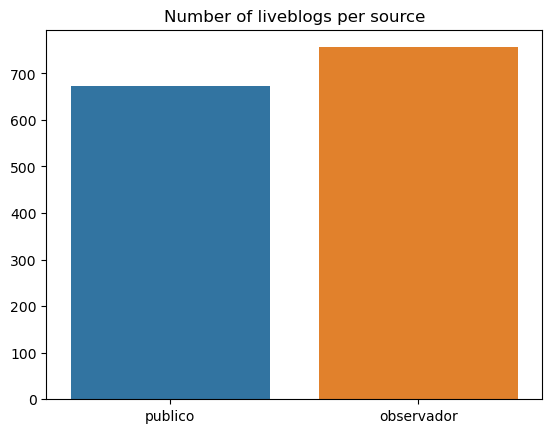

In [8]:
sources = list(collection_stats.keys())
n_lbs = [v['num_lbs'] for _, v in collection_stats.items()]

ax = sns.barplot(x=sources, y=n_lbs)
ax.set_title('Number of liveblogs per source');

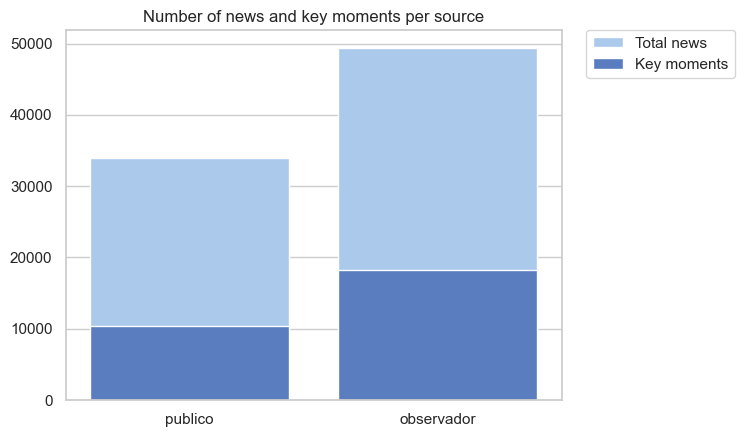

In [9]:
sns.set_theme(style="whitegrid")

sources = list(collection_stats.keys())

sns.set_color_codes("pastel")
n_news = [v['num_news'] for _, v in collection_stats.items()]
ax = sns.barplot(x=sources, y=n_news, label="Total news", color="b")

sns.set_color_codes("muted")
n_kms = [v['num_kms'] for _, v in collection_stats.items()]
ax = sns.barplot(x=sources, y=n_kms, label="Key moments", color="b")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Number of news and key moments per source');

### Zip data and save to GDrive

## Preprocess datasets

### Requirements

In [10]:
!pip install -U pandas

In [11]:
import os
from pathlib import Path
import pandas as pd

In [12]:
pd.set_option('display.max_colwidth', 2000)

In [66]:
# The root directory where the datasets are placed
DATA_DIR = 'data/'

# Create python vars with the datasets location
DATA_DIR_PUBLICO = os.path.join(DATA_DIR, 'publico/')
NEWS_PUBLICO = os.path.join(DATA_DIR_PUBLICO, 'news_publico.json')

DATA_DIR_OBSERVADOR = os.path.join(DATA_DIR, 'observador/')
NEWS_OBSERVADOR = os.path.join(DATA_DIR_OBSERVADOR, 'news_observador.json')

DATA_DIR_CNN = os.path.join(DATA_DIR, 'cnn/')
NEWS_CNN = os.path.join(DATA_DIR_CNN, 'news_cnn.json')
KMS_CNN = os.path.join(DATA_DIR_CNN, 'kms_cnn.json')

DATA_DIR_GUARDIAN = os.path.join(DATA_DIR, 'guardian/')
NEWS_GUARDIAN = os.path.join(DATA_DIR_GUARDIAN, 'news_guardian.json')

In [67]:
def pre_proc(df_news, noisy_strs_title, noisy_strs_text):
  # Exception handling because CNN KMs do not have text column. Only have title

  # Remove rows with NaN in title or text
  df_news = df_news.dropna(subset=['title'])
  try:
    df_news = df_news.dropna(subset=['text'])
  except KeyError as ke:
    pass

  # Remove rows containing containing noisy strings in title
  df_news = df_news[~df_news['title'].str.contains('|'.join(noisy_strs_title), case=False)]

  # Remove noisy strings from news content
  try:
    df_news['text'] = df_news['text'].str.replace('|'.join(noisy_strs_text), '')
  except KeyError as ke:
    pass

  # Uniformize quotation marks
  df_news['title'] = df_news['title'].str.replace('“|”', '"')

  try:
    df_news['text'] = df_news['text'].str.replace('“|”', '"')
  except KeyError as ke:
    pass

  # Remove rows with empty title or text
  df_news = df_news[df_news['title'] != '']
  try:
    df_news = df_news[df_news['text'] != '']
  except KeyError as ke:
    pass

  # Drop duplicated news with same title, text and date, keeping first occurence
  try:
    df_news = df_news.drop_duplicates(subset=['title', 'text', 'date'])
  except KeyError as ke:
    df_news = df_news.drop_duplicates(subset=['title', 'date'])

  
  # Reorder index
  df_news = df_news.reset_index(drop=True)

  return df_news


def write_df_to_json(df, file_path):
  df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M')
  df.to_json(file_path, orient='records', force_ascii=False, indent=4)


# The root directory where the prepocessed datasets will be placed
DATA_CLEAN_DIR = 'data_clean/'
# Create dir if does not exist
Path(DATA_CLEAN_DIR).mkdir(parents=True, exist_ok=True)

### PT

In the data collection step we generated two .json files (news and kms) for the sake of separation. The news contains all the liveblog standard news as well as the keymoments. So news.json contains all the news articles. In order to standardize and avoid redundancy, in the pre processing step we will only work with the news.json.

#### Publico


In [68]:
noisy_strs_title_publico = [
                        'A primeira página do PÚBLICO',
                        'Fim do acompanhamento',
                        'Quatro opiniões para ler',
                        'Ponto de situação',
                        'Encerramento da cobertura',
                        'Os números da pandemia',
                        'Encerramento do acompanhamento',
                        'Os destaques',
                        'para começar o dia',
                        'a ler',
                        'Vale a pena ler',
                        'o que precisa de saber',
                        'o que deve saber',
                        'Os números actualizados da pandemia',
                        'Os números mundiais da pandemia',
                        'Os últimos números da pandemia',
                        'O número de casos do novo coronavírus',
                        'Acompanhe em directo a conferência',
                        'Veja a conferência de imprensa',
                        'Acompanhe a conferência de imprensa',
                        'Veja em directo a conferência',
                        'Bom dia',
                        'Boa noite',
                        'Resumo dos acontecimentos',
                        'resumo do dia',
                        'resumo da manhã',
                        '^resumo$',
                        '^encerramento$'
]

noisy_strs_text_publico = [
                        r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                        r'<span(.*?)>',
                        r'Normal 0 21(.*)',

                        r'^Leia(.*)aqui(.*)',
                        r' Leia(.*)aqui(.*)',
                        r' Leia a entrevista(.*)',
                        r' Leia a reportagem(.*)',
                        r' Leia o resto da reportagem(.*)',
                        r' Leia o artigo(.*)',
                        r' Leia a notícia(.*)',
                        r' Leia o texto(.*)',
                        r' Leia mais(.*)',
                        r' Saiba mais(.*)',
                        r' Ler mais(.*)',
                        r' Leia também(.*)',
                        r'pic.twitter.com/[a-zA-Z0-9]+(\s|$)'
]

In [69]:
# Load json dataset into pandas dataframe
df_publico_lb = pd.read_json(NEWS_PUBLICO)

In [70]:
# Preprocess dataset
df_publico_lb = pre_proc(df_publico_lb, noisy_strs_title_publico, noisy_strs_text_publico)

In [106]:
df_publico_lb.describe()
print(type(df_publico_lb))

KeyboardInterrupt: 

In [72]:
df_publico_lb.head()

,title,text,date,is_km,url
0,Prigozhin dá prova de vida a receber os seus mercenários na Bielorrússia,"O líder do grupo Wagner, Yevgeny Prigozhin, apareceu em público pela primeira vez desde a rebelião de Junho, num vídeo divulgado esta quarta-feira nas redes sociais, no qual dá as boas vindas aos combatentes do grupo mercenário na Bielorrússia. No vídeo, cuja autenticidade a Reuters não conseguiu verificar de imediato, Prigozhin (Ievgueni Prigojin na transliteração portuguesa) confirma que, por enquanto, os seus mercenários não voltarão a combater na Ucrânia, elegendo as operações em África como o objec...",2023-07-19 20:27:00,False,https://www.publico.pt/2023/07/19/mundo/noticia/duas-mil-pessoas-retiradas-crimeia-apos-incendio-explosoes-2057362#95683
1,"Cruz Vermelha bielorrussa envolvida na transferência de crianças ucranianas da Ucrânia para a Bielorrússia, diz presidente","O presidente da Cruz Vermelha da Bielorrússia disse à televisão estatal daquele país que a organização tem estado envolvida na transferência de crianças ucranianas, prática que a justiça internacional equipara a um crime contra a humanidade. Dzmitry Shautsou disse que ""a Cruz Vermelha bielorrussa esteve e continuará a estar envolvida nisso"", acrescentando que as crianças são transferidas para a Bielorrússia por motivos de saúde, avança a Sky News. A Ucrânia e a oposição bielorrussa já denunciaram a situ...",2023-07-19 19:46:00,False,https://www.publico.pt/2023/07/19/mundo/noticia/duas-mil-pessoas-retiradas-crimeia-apos-incendio-explosoes-2057362#95682
2,"Putin acusa Ocidente de ""distorcer"" âmbito do acordo de cereais, mas admite regressar ao tratado","O Presidente russo acusou esta quarta-feira os países ocidentais de distorcerem o âmbito do acordo de cereais do mar Negro. No entanto, Vladimir Putin admitiu que a Rússia pode regressar ao tratado se todas as exigências de Moscovo forem cumpridas. ""Inicialmente, a essência do acordo de cereais tinha um significado humanitário colossal"", disse Putin. ""O Ocidente distorceu completamente essa essência e, em vez de ajudar os países realmente necessitados, usou o acordo de cereais para chantagem política"", ...",2023-07-19 18:50:00,True,https://www.publico.pt/2023/07/19/mundo/noticia/duas-mil-pessoas-retiradas-crimeia-apos-incendio-explosoes-2057362#95681
3,Kiev propõe força internacional no mar Negro para proteger carregamentos de cereais,"A Ucrânia propõe que sejam criadas patrulhas internacionais, sob mandato da ONU, para garantir a segurança das suas exportações de cereais através do mar Negro, após a retirada da Rússia do acordo que garantia a segurança do transporte marítimo na região. “Devemos mandatar a ONU para criar patrulhas militares” com a participação de países da região do mar Negro, como a Turquia e a Bulgária, disse à AFP Mykhailo Podoliak, conselheiro da Presidência ucraniana. A Rússia alertara que considerará a partir da...",2023-07-19 18:31:00,True,https://www.publico.pt/2023/07/19/mundo/noticia/duas-mil-pessoas-retiradas-crimeia-apos-incendio-explosoes-2057362#95680
4,"EUA anunciam novo pacote de ajuda militar para a Ucrânia, no valor de 1,2 mil milhões de euros","Os Estados Unidos anunciaram esta quarta-feira um novo pacote de ajuda militar de cerca de 1,3 mil milhões de dólares (cerca de 1,2 mil milhões de euros) para a Ucrânia. O pacote inclui sistemas de defesa aérea, drones e munições. ""Este anúncio representa o início de um processo de contratação para fornecer capacidades prioritárias adicionais à Ucrânia"", afirmou o Pentágono em comunicado. No início deste mês, os Estados Unidos anunciaram o envio de bombas de fragmentação, que são proibidas em mais de 10...",2023-07-19 18:14:00,True,https://www.publico.pt/2023/07/19/mundo/noticia/duas-mil-pessoas-retiradas-crimeia-apos-incendio-explosoes-2057362#95679


In [73]:
# Place publico data under data_clean/publico
DATA_CLEAN_DIR_PUBLICO = os.path.join(DATA_CLEAN_DIR, 'publico/')
# Create dir if does not exist
Path(DATA_CLEAN_DIR_PUBLICO).mkdir(parents=True, exist_ok=True)

publico_news_clean_path = os.path.join(DATA_CLEAN_DIR_PUBLICO, 'news_publico.json')
write_df_to_json(df_publico_lb, publico_news_clean_path)

#### Observador

In [74]:
noisy_strs_title_observador = [
                        'Ponto da situação',
                        'Ponto de situação no mundo',
                        'Os pontos mais importantes do dia até ao momento'
]

noisy_strs_text_observador = [
                        r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                        r' Leia a notícia(.*)',
                        r' Pode ler mais(.*)',
                        r' Ler mais(.*)',
                        r' Saiba mais(.*)',
                        r'Leia mais aqui(.)*',
                        r'\(?([A-Z]+(\s)*)*/OBSERVADOR\)?',
                        r'(\(?Agência\)?\s*)?Lusa\)?$',
                        r'pic.twitter.com/[a-zA-Z0-9]+(\s|$)'
]

In [75]:
# Load json dataset into pandas dataframe
df_observador_lb = pd.read_json(NEWS_OBSERVADOR)

In [76]:
# Preprocess dataset
df_observador_lb = pre_proc(df_observador_lb, noisy_strs_title_observador, noisy_strs_text_observador)

In [77]:
df_observador_lb.describe()

,date
count,47621
mean,2020-12-08 15:50:14.977005824
min,2020-01-30 19:01:00
25%,2020-05-17 12:35:00
50%,2020-11-14 12:08:00
75%,2021-05-19 07:21:00
max,2022-11-11 17:13:00


In [78]:
df_observador_lb.head()

,title,text,date,is_km,url
0,"Sem medidas ""obrigatórias"" e com foco na lição aprendida com a pandemia (e na vacina). O que saiu da primeira reunião de Pizarro no Infarmed","Primeira reunião no Infarmed de Manuel Pizarro terminou sem recomendações para mais medidas, sem debate à porta fechada entre cientistas e peritos mas com uma certeza: a vacinação “faz a diferença”. Sem medidas “obrigatórias” e com foco na lição aprendida com a pandemia (e na vacina). O que saiu da primeira reunião de Pizarro no Infarmed",2022-11-11 17:13:00,False,https://observador.pt/liveblogs/peritos-e-governo-reunem-no-infarmed-para-fazer-um-ponto-de-situacao-sobre-a-covid-19/#liveblog-entry-591496
1,"BE: ""Bom passo era o ministro da Saúde deixar de estar em negação""","Na reação à reunião do Infarmed, Moisés Ferreira diz que “um bom primeiro passo era o ministro da Saúde deixar de estar em negação” e que “abandonasse o que tem vindo a dizer sobre a proposta de OE para 2023 que prevê um aumento de 2,9%”. O bloquista pediu ainda o “regresso dos testes gratuitos e a baixa médica paga a 100%”. “Seria muito útil que o Governo fizesse 2 coisas: que o ministro da Saúde deixasse de estar em negação em relação à situação difícil que os hospitais do SNS estão a passar e que aba...",2022-11-11 11:55:00,True,https://observador.pt/liveblogs/peritos-e-governo-reunem-no-infarmed-para-fazer-um-ponto-de-situacao-sobre-a-covid-19/#liveblog-entry-591441
2,IL satisfeita com tónica na responsabilidade individual,"Rodrigo Saraiva, líder parlamentar da IL, comenta a reunião do Infarmed, que “decorreu da forma tranquila”, ainda que assuma que “estávamos condicionados com a gestão de expectativas”. Rodrigo Saraiva diz que não houve “medidas drásticas a serem tocadas nesta reunião. Foi uma reunião tranquila. Não existiram grandes sinais de alerta” e o deputado salienta que a Covid está a seguir linha de outras infeções respiratórias e a ser gerida dessa forma. “Gostámos muito desta reunião em que houve foco na respon...",2022-11-11 11:45:00,True,https://observador.pt/liveblogs/peritos-e-governo-reunem-no-infarmed-para-fazer-um-ponto-de-situacao-sobre-a-covid-19/#liveblog-entry-591440
3,"Máscaras de volta? Quem está doente deve usar, mas a regra é deixar à ""avaliação de cada um""","O ministro da Saúde foi também questionado sobre se está em cima da mesa um regresso das máscaras no inverno e respondeu que é preciso “virar a página do período mais difícil desta pandemia”. “Temos de fazer, sobretudo, uma mensagem de pedagogia”, disse. “As pessoas que estiverem doentes, mesmo que se trate de uma vulgar constipação, de uma infeção ligeira, tenham uma dor de garganta, tenham corrimento nasal, devem usar máscara sobretudo para proteger os outros”, afirmou o ministro. “Claro, as pessoas q...",2022-11-11 11:42:00,True,https://observador.pt/liveblogs/peritos-e-governo-reunem-no-infarmed-para-fazer-um-ponto-de-situacao-sobre-a-covid-19/#liveblog-entry-591439
4,"Manuel Pizarro garante que situação é de ""normalidade"" nas urgências","Questionado sobre os constrangimentos sentidos nas urgências hospitalares portuguesas nos últimos dias, Manuel Pizarro assumiu que eles existiram, mas adiantou que a situação atual é de “normalidade” e agradeceu aos profissionais de saúde pelo esforço. Pizarro salientou também que os dados fornecidos pelos peritos ajudam a preparar o plano para o inverno, que já foi antecipado com base nas experiências observadas no hemisfério sul.",2022-11-11 11:39:00,True,https://observador.pt/liveblogs/peritos-e-governo-reunem-no-infarmed-para-fazer-um-ponto-de-situacao-sobre-a-covid-19/#liveblog-entry-591437


In [79]:
# Place observador data under data_clean/observador
DATA_CLEAN_DIR_OBSERVADOR = os.path.join(DATA_CLEAN_DIR, 'observador/')
# Create dir if does not exist
Path(DATA_CLEAN_DIR_OBSERVADOR).mkdir(parents=True, exist_ok=True)

observador_news_clean_path = os.path.join(DATA_CLEAN_DIR_OBSERVADOR, 'news_observador.json')
write_df_to_json(df_observador_lb, observador_news_clean_path)

### EN

#### CNN
Here we have to deal with the two jsons separately as the news_cnn.json does not contain the news in kms_cnn.json

#### Guardian

## Generate TLS dataset

[Timeline17](http://www.l3s.de/~gtran/timeline/) structure

Use key moments to identify entities and keywords of interest. We refer to the set of entities and keywords as topics.

### Requirements

In [27]:
# Not necessary to run this cell
# Just to check which GPU is allocated (P100 > T4 > P4 > K80) and CUDA version
!nvidia-smi

Thu Jul 20 22:52:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              25W / 115W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
!pip install -U pandas
!pip install -U spacy[cuda101]
!python -m spacy download en_core_web_sm
!python -m spacy download pt_core_news_sm
!pip install git+https://github.com/LIAAD/yake
!pip install unidecode
!pip install syntok

INFO: pip is looking at multiple versions of spacy[cuda101] to determine which version is compatible with other requirements. This could take a while.
  Using cached spacy-3.6.0-cp311-cp311-win_amd64.whl (12.3 MB)
  Using cached spacy-3.5.4-cp311-cp311-win_amd64.whl (12.2 MB)
  Using cached spacy-3.5.3-cp311-cp311-win_amd64.whl (12.2 MB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached spacy-3.5.2-cp311-cp311-win_amd64.whl (12.2 MB)
INFO: pip is looking at multiple versions of spacy[cuda101] to determine which version is compatible with other requirements. This could take a while.
  Using cached spacy-3.5.1-cp311-cp311-win_amd64.whl (12.2 MB)
  Using cached spacy-3.5.0-cp311-cp311-win_amd64.whl (12.2 MB)
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached spacy-3.4.4

  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [472 lines of output]
    Using cached setuptools-68.0.0-py3-none-any.whl (804 kB)
    Using cached Cython-0.29.36-py2.py3-none-any.whl (988 kB)
    Using cached cymem-2.0.7-cp311-cp311-win_amd64.whl (28 kB)
    Using cached preshed-3.0.8-cp311-cp311-win_amd64.whl (91 kB)
    Using cached murmurhash-1.0.9-cp311-cp311-win_amd64.whl (18 kB)
    Using cached thinc-8.0.17.tar.gz (189 kB)
    Installing build dependencies: started
    Installing build dependencies: finished with status 'done'
    Getting requirements to build wheel: started
    Getting requirements to build wheel: finished with status 'done'
    Installing backend dependencies: started
    Installing backend dependencies: finished with status 'done'
    Preparing metadata (pyproject.toml): started
    Preparing metadata (pyproject.toml): finished with status 'done'
    Using cached blis-0.7.1

                                              0.0/12.8 MB ? eta -:--:--
     -                                        0.6/12.8 MB 12.6 MB/s eta 0:00:01
     -----                                    1.6/12.8 MB 17.2 MB/s eta 0:00:01
     ----------                               3.2/12.8 MB 22.7 MB/s eta 0:00:01
     --------------                           4.8/12.8 MB 25.4 MB/s eta 0:00:01
     --------------------                     6.5/12.8 MB 27.5 MB/s eta 0:00:01
     ----------------------------             9.2/12.8 MB 32.6 MB/s eta 0:00:01
     ------------------------------------    12.1/12.8 MB 46.9 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 46.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 36.3 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
                                              0.0/13.0 MB ? eta -:--:--
     ------                      

  Cloning https://github.com/LIAAD/yake to c:\users\25031\appdata\local\temp\pip-req-build-lfveyo2y
  Resolved https://github.com/LIAAD/yake to commit 374fc1c1c19eb080d5b6115cbb8d4a4324392e54
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/LIAAD/yake 'C:\Users\25031\AppData\Local\Temp\pip-req-build-lfveyo2y'


In [13]:
!pip install git+https://github.com/LIAAD/yake
!pip install unidecode
!pip install syntok

  Cloning https://github.com/LIAAD/yake to c:\users\25031\appdata\local\temp\pip-req-build-zdxtnymp
  Resolved https://github.com/LIAAD/yake to commit 374fc1c1c19eb080d5b6115cbb8d4a4324392e54
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/LIAAD/yake 'C:\Users\25031\AppData\Local\Temp\pip-req-build-zdxtnymp'


In [14]:
import os
import json
import re
from pathlib import Path

import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import spacy
spacy_gpu = spacy.prefer_gpu()
print('spaCy GPU enabled:', spacy_gpu)
import pt_core_news_sm
import en_core_web_sm

import yake

import unidecode

import syntok.segmenter as segmenter

spaCy GPU enabled: False


In [15]:
pd.set_option('display.max_colwidth', 512)

In [16]:
YAKE_PARAMS = {
    'language': '',
    'max_ngram_size': 4,
    'deduplication_thresold': 0.9,
    'deduplication_algo': 'seqm',
    'windowSize': 1,
    'numOfKeywords': 3
}

LAN_PT = 'pt'
LAN_EN = 'en'

In [17]:
# The root directory where the datasets are placed
DATA_DIR = 'data_clean/'

# Create python vars with the datasets location
DATA_DIR_PUBLICO = os.path.join(DATA_DIR, 'publico/')
NEWS_PUBLICO = os.path.join(DATA_DIR_PUBLICO, 'news_publico.json')

DATA_DIR_OBSERVADOR = os.path.join(DATA_DIR, 'observador/')
NEWS_OBSERVADOR = os.path.join(DATA_DIR_OBSERVADOR, 'news_observador.json')

DATA_DIR_CNN = os.path.join(DATA_DIR, 'cnn/')
NEWS_CNN = os.path.join(DATA_DIR_CNN, 'news_cnn.json')
KMS_CNN = os.path.join(DATA_DIR_CNN, 'kms_cnn.json')

DATA_DIR_GUARDIAN = os.path.join(DATA_DIR, 'guardian/')
NEWS_GUARDIAN = os.path.join(DATA_DIR_GUARDIAN, 'news_guardian.json')

### Functions

In [18]:
def concatenate_title_text(df_news):
  try:
    df_news['title_and_text'] = df_news['title'] + '. ' + df_news['text']
  except KeyError:
    df_news['title_and_text'] = df_news['title']

  # Drop duplicates by title_and_text, keeping first occurence
  df_news = df_news.drop_duplicates(subset=['title_and_text'])

  return df_news

# Return a list set (without duplicates)
# as we are not interested in how many times an entity appears
# but rather if it appears or not
def get_ents(nlp, text):
  
  try:
    doc = nlp(text)

    ents = [ent.text.lower() for ent in doc.ents]
  
    return list(set(ents))

  except TypeError as te:
    return []

def get_kws(kw_extractor, text):

  try: 
    keywords = kw_extractor.extract_keywords(text)
    kws_without_scores = [kw[0] for kw in keywords]

    return list(set(kws_without_scores))
  
  except ValueError:
    return []
  except AttributeError:
    return []

def parse_name(text):
  
  text = text.replace(' ', '_')

  text = text.lower()
  text = unidecode.unidecode(text)

  return text

def write_json(file_path, json_data):
    #print('Writing ' + file_path)
    with open(file_path, 'w', encoding='utf8') as fp:
        json.dump(json_data, fp, ensure_ascii=False, indent=4)

In [19]:
# Fucntions related to writing the datasets 

# Valid languages
LANGUAGES = ['pt', 'en']


def get_sents(text):
  sentences = []
  for paragraph in segmenter.process(text):
    for sentence in paragraph:
      s_sentence = ''
      for token in sentence:
        s_sentence += token.value + ' '
      sentences.append(s_sentence)
  
  return sentences


def get_inputDocs(df, topics):
  gt = []
  for i, topic in enumerate(topics):
    print(str(i+1) + '/' + str(len(topics)))
    print(topic)
    inner_dict = {}
    topic_name = topic[0]
    # If single topic, without synonyms
    if len(topic) == 1:
      # topic_name = topic[0].replace('-', '_')
      df_loc = df[df.apply(lambda r: topic_name in r['topics'], axis=1)][['date', 'title', 'text', 'url']].iloc[::-1]
    # If topic with synonyms
    else:
      dfs = []
      for st in topic:
        df_sub = df[df.apply(lambda r: st in r['topics'], axis=1)][['date', 'title', 'text', 'url']].iloc[::-1]
        dfs.append(df_sub)
      # Merge topics
      df_loc = pd.concat(dfs)
      # Remove possible duplicates from merging topics
      df_loc = df_loc.drop_duplicates(subset=['date', 'title', 'text', 'url'])
      # topic_name = '-'.join([t.replace('-','_') for t in topic])
    
    inner_dict[topic_name] = df_loc.to_dict(orient='records')
    gt.append(inner_dict)

  # Convert to format {ent: {date: [list_news]}}
  input_docs = {}
  for topic in gt:
    for k, v in topic.items():
      inner_dict = {}
      for news in v:
        inner_dict.setdefault(news['date'],[]).append((news['title'], news['text'], news['url']))

      input_docs[k] = inner_dict

  return input_docs


def write_inputDocs(dataset, lan, source_name, with_json=False):
  
  if lan not in LANGUAGES:
    print('Please provide a valid language')
    return

  dataset_dir = 'dataset_' + lan

  dataset_dir_txt = os.path.join(dataset_dir, 'txt/')
  Path(dataset_dir_txt).mkdir(parents=True, exist_ok=True)

  if with_json:
    dataset_dir_json = os.path.join(dataset_dir, 'json/')
    Path(dataset_dir_json).mkdir(parents=True, exist_ok=True)

  source_name_suffix = '_' + source_name

  for i, topic in enumerate(dataset):
    print(str(i+1) + '/' + str(len(dataset)))
    print(topic)

    file_name = parse_name(topic)

    # TXT
    ent_dir_txt = os.path.join(dataset_dir_txt, file_name + source_name_suffix)
    ent_dir_txt = str(ent_dir_txt).replace('\\', '/')
    ent_dir_txt = str(ent_dir_txt).replace('\\\\', '/')
    ent_dir_txt = str(ent_dir_txt).replace('\"', '') 
    #print("\n\nent_dir_txt : ",ent_dir_txt)
    Path(ent_dir_txt).mkdir(parents=True, exist_ok=True)

    ent_inputdocs_txt = os.path.join(ent_dir_txt, 'input_docs/')
    ent_inputdocs_txt = str(ent_inputdocs_txt).replace('\\', '/')
    ent_inputdocs_txt = str(ent_inputdocs_txt).replace('\\\\', '/')
    ent_inputdocs_txt = str(ent_inputdocs_txt).replace('\"', '')   
    Path(ent_inputdocs_txt).mkdir(parents=True, exist_ok=True)

    if with_json:
      # JSON
      ent_dir_json = os.path.join(dataset_dir_json, file_name + source_name_suffix)
      Path(ent_dir_json).mkdir(parents=True, exist_ok=True)

      ent_inputdocs_json = os.path.join(ent_dir_json, 'input_docs/')
      Path(ent_inputdocs_json).mkdir(parents=True, exist_ok=True)

    for date, news in dataset[topic].items():
      
      # TXT
      ent_inputdocs_liveblog_day_txt = os.path.join(ent_inputdocs_txt, date)
      Path(ent_inputdocs_liveblog_day_txt).mkdir(parents=True, exist_ok=True)

      counter = 0
      for n in news:
        fn = str(counter) + '.txt'
        file_path_txt_inputdocs = os.path.join(ent_inputdocs_liveblog_day_txt, fn)
        with open(file_path_txt_inputdocs, 'a', encoding='utf8') as txt_file:
          # n[1] is text
          news_sents = get_sents(n[1])
          for ns in news_sents:
            txt_file.write(ns + '\n')
        counter += 1

        
      if with_json:
        # JSON
        ent_inputdocs_liveblog_day_json = os.path.join(ent_inputdocs_json, date)
        Path(ent_inputdocs_liveblog_day_json).mkdir(parents=True, exist_ok=True)

        counter = 0
        for n in news:
          fn = str(counter) + '.json'
          file_path_json_inputdocs = os.path.join(ent_inputdocs_liveblog_day_json, fn)
          # n[1] is text
          news_sents = get_sents(n[1])
          write_json(file_path_json_inputdocs, news_sents)
          counter += 1
        

def get_timelines(df, topics):
  gt = []

  for i, topic in enumerate(topics):
    print(str(i+1) + '/' + str(len(topics)))
    print(topic)
    inner_dict = {}
    topic_name = topic[0]
    # If single topic, without synonyms
    if len(topic) == 1:
      # topic_name = topic[0].replace('-', '_')
      df_loc = df[df.apply(lambda r: topic_name in r['topics'], axis=1)][['date', 'title', 'text', 'url']].iloc[::-1]
    # If topic with synonyms
    else:
      dfs = []
      for st in topic:
        df_loc = df[df.apply(lambda r: st in r['topics'], axis=1)][['date', 'title', 'text', 'url']].iloc[::-1]
        dfs.append(df_loc)
      # Merge topics
      df_loc = pd.concat(dfs)
      # Remove possible duplicates from merging topics
      df_loc = df_loc.drop_duplicates(subset=['date', 'title', 'text', 'url'])
      # topic_name = '-'.join([t.replace('-','_') for t in topic])

    inner_dict[topic_name] = df_loc.to_dict(orient='records')
    gt.append(inner_dict)

  # Convert to format {ent: {date: [list_news]}}
  timelines = {}
  for topic in gt:
    for k, v in topic.items():
      inner_dict = {}
      for news in v:
        inner_dict.setdefault(news['date'],[]).append((news['title'], news['text'], news['url']))

      timelines[k] = inner_dict

  return timelines


def write_timelines(dataset, lan, source_name, with_json=False):

  if lan not in LANGUAGES:
    print('Please provide a valid language')
    return

  dataset_dir = 'dataset_' + lan

  dataset_dir_txt = os.path.join(dataset_dir, 'txt/')
  Path(dataset_dir_txt).mkdir(parents=True, exist_ok=True)

  if with_json:
    dataset_dir_json = os.path.join(dataset_dir, 'json/')
    dataset_dir_json = str(dataset_dir_json).replace('\\', '/')
    dataset_dir_json = str(dataset_dir_json).replace('\\\\', '/')      
    Path(dataset_dir_json).mkdir(parents=True, exist_ok=True)

  source_name_suffix = '_' + source_name

  txt_delimiter = '--------------------------------'

  for i, topic in enumerate(dataset):
    print(str(i+1) + '/' + str(len(dataset)))
    print(topic)

    file_name = parse_name(topic)

    # TXT
    file_name_txt = file_name + '.txt'

    ent_timelines_keymoments_txt = os.path.join(dataset_dir_txt, file_name + source_name_suffix, 'timelines')
    ent_timelines_keymoments_txt = str(ent_timelines_keymoments_txt).replace('\\', '/')
    ent_timelines_keymoments_txt = str(ent_timelines_keymoments_txt).replace('\\\\', '/')    
    ent_timelines_keymoments_txt = str(ent_timelines_keymoments_txt).replace('\"', '') 
    Path(ent_timelines_keymoments_txt).mkdir(parents=True, exist_ok=True)

    file_path_txt = os.path.join(ent_timelines_keymoments_txt, file_name_txt)
    file_path_txt = str(file_path_txt).replace('\\', '/')
    file_path_txt = str(file_path_txt).replace('\\\\', '/')    
    file_path_txt = str(file_path_txt).replace('\"', '')     

    for k, v in dataset[topic].items():
      with open(file_path_txt, 'a', encoding='utf8') as txt_file:
        txt_file.write(k + '\n')
        for news in v:
          # news[0] is title
          txt_file.write(news[0] + '\n')
        txt_file.write(txt_delimiter + '\n')
    
    if with_json:
      # JSON
      file_name_json = file_name + '.json'

      ent_timelines_keymoments_json = os.path.join(dataset_dir_json, file_name + source_name_suffix, 'timelines')
      ent_timelines_keymoments_json = str(ent_timelines_keymoments_json).replace('\\', '/')
      ent_timelines_keymoments_json = str(ent_timelines_keymoments_json).replace('\\\\', '/')       
      Path(ent_timelines_keymoments_json).mkdir(parents=True, exist_ok=True)

      file_path_json = os.path.join(ent_timelines_keymoments_json, file_name_json)
      
      json_data_to_write = {}
      for date, news_list in dataset[topic].items():
        json_data_to_write[date] = [news[0] for news in news_list]

      write_json(file_path_json, json_data_to_write)


# Function to write data in bulk to json
def data_to_cmh(data, source, lan):
  news_list = []

  for topic, content in data.items():
    for date, news in content.items():
      for n in news:
        news_dict = {}
        news_dict['source'] = source
        news_dict['lan'] = lan
        news_dict['topic'] = topic
        news_dict['date'] = str(date)
        news_dict['title'] = n[0]
        news_dict['news'] = n[1]
        news_dict['url'] = n[2]
        news_list.append(news_dict)

  return news_list

### PT

In [20]:
# Load Spacy pt ner model
nlp_ner_pt = pt_core_news_sm.load(disable=['tagger', 'parser'])

# YAKE pt
YAKE_PARAMS['language'] = LAN_PT

kw_extractor_pt = yake.KeywordExtractor(
            lan=YAKE_PARAMS['language'], top=YAKE_PARAMS['numOfKeywords'])

#### Publico

In [21]:
df_publico_lb = pd.read_json(NEWS_PUBLICO)
#print(NEWS_PUBLICO)
# Create a new column with the concatenation of title and text (used to find topics)
df_publico_lb = concatenate_title_text(df_publico_lb)

##### Get topics

In [22]:
print('Getting spaCy entities')
df_publico_lb['ents'] = df_publico_lb['title_and_text'].progress_apply(lambda t: get_ents(nlp_ner_pt, t))

print('Getting yake keywords')
df_publico_lb['kws'] = df_publico_lb['title_and_text'].progress_apply(lambda t: get_kws(kw_extractor_pt, t))

print('Merging entities and keywords')
df_publico_lb['topics'] = df_publico_lb.progress_apply(lambda r: list(set(r['ents'] + r['kws'])), axis=1)

Getting spaCy entities


100%|████████████████████████████████████████████████████████████████████████████| 31885/31885 [06:19<00:00, 83.91it/s]


Getting yake keywords


100%|███████████████████████████████████████████████████████████████████████████| 31885/31885 [04:49<00:00, 110.01it/s]


Merging entities and keywords


100%|████████████████████████████████████████████████████████████████████████| 31885/31885 [00:00<00:00, 102168.49it/s]


#### Observador

In [23]:
df_observador_lb = pd.read_json(NEWS_OBSERVADOR)

# Create a new column with the concatenation of title and text (used to find topics)
df_observador_lb = concatenate_title_text(df_observador_lb)

##### Get topics

In [24]:
print('Getting spaCy entities')
df_observador_lb['ents'] = df_observador_lb['title_and_text'].progress_apply(lambda t: get_ents(nlp_ner_pt, t))

print('Getting yake keywords')
df_observador_lb['kws'] = df_observador_lb['title_and_text'].progress_apply(lambda t: get_kws(kw_extractor_pt, t))

print('Merging entities and keywords')
df_observador_lb['topics'] = df_observador_lb.progress_apply(lambda r: list(set(r['ents'] + r['kws'])), axis=1)

Getting spaCy entities


100%|████████████████████████████████████████████████████████████████████████████| 47564/47564 [08:35<00:00, 92.18it/s]


Getting yake keywords


100%|███████████████████████████████████████████████████████████████████████████| 47564/47564 [06:07<00:00, 129.41it/s]


Merging entities and keywords


100%|█████████████████████████████████████████████████████████████████████████| 47564/47564 [00:00<00:00, 67405.08it/s]


#### Topics selection

##### Count topics occurences

In [25]:
# Topics are chosen based on their occurence in key moments

df_publico_km = df_publico_lb.loc[df_publico_lb['is_km'] == 'True']

df_observador_km = df_observador_lb.loc[df_observador_lb['is_km'] == 'True']

In [26]:
# For each source create a list of lists with topics. Each inner list corresponds to a news. Used to keep track of the number of news in which each topic appears

publico_topics_per_news_km = df_publico_km.topics.tolist()

observador_topics_per_news_km = df_observador_km.topics.tolist()

In [27]:
# List topics for Portuguese

publico_km_topics = set([a for b in publico_topics_per_news_km for a in b])

observador_km_topics = set([a for b in observador_topics_per_news_km for a in b])

pt_km_topics = list(set(publico_km_topics | observador_km_topics))

In [28]:
# For each topic count the number of key moments per source in which it appears

pt_km_topics_count = {}

for topic in tqdm(pt_km_topics):
    
  source_topic_count = {}

  source_topic_count['publico'] = len([list_of_topics for list_of_topics in publico_topics_per_news_km if topic in list_of_topics])
  
  source_topic_count['observador'] = len([list_of_topics for list_of_topics in observador_topics_per_news_km if topic in list_of_topics])

  pt_km_topics_count[topic] = source_topic_count

len(pt_km_topics_count)

100%|████████████████████████████████████████████████████████████████████████████| 60997/60997 [14:21<00:00, 70.81it/s]


60997

In [29]:
# Filter topics by minimum number of occurrences

MIN_NUM_KEY_MOMENTS = 5

for topic, counts in list(pt_km_topics_count.items()):

  # delete topic if there are less than MIN_NUM_KEY_MOMENTS key moments in one of the sources
  if (counts['publico'] < MIN_NUM_KEY_MOMENTS or counts['observador'] < MIN_NUM_KEY_MOMENTS):
    del pt_km_topics_count[topic]

len(pt_km_topics_count)

1560

##### Keymoments/liveblog ratio

In [30]:
# For each source create a list of lists with topics. Each inner list corresponds ta a news. Used to keep track of the number of news in which each topic appears

publico_topics_per_news_lb = df_publico_lb.topics.tolist()

observador_topics_per_news_lb = df_observador_lb.topics.tolist()

In [31]:
# For each topic copute a ratio of occurences between key moments and liveblog per source

ratio_dict_pt = {}

for topic in tqdm(pt_km_topics_count):

  # Count occurences in liveblog
  publico_lb_count = len([list_of_topics for list_of_topics in publico_topics_per_news_lb if topic in list_of_topics])
  observador_lb_count = len([list_of_topics for list_of_topics in observador_topics_per_news_lb if topic in list_of_topics])

  publico_km_count = pt_km_topics_count[topic]['publico']
  observador_km_count = pt_km_topics_count[topic]['observador']

  inner_dict = {}

  inner_dict['publico_lb_count'] = publico_lb_count
  inner_dict['publico_km_count'] = publico_km_count
  if publico_lb_count < 1:
    inner_dict['publico_ratio_km_lb'] = 0
  else:
    inner_dict['publico_ratio_km_lb'] = publico_km_count/publico_lb_count

  inner_dict['observador_lb_count'] = observador_lb_count
  inner_dict['observador_km_count'] = observador_km_count
  if observador_lb_count < 1:
    inner_dict['observador_ratio_km_lb'] = 0
  else:
    inner_dict['observador_ratio_km_lb'] = observador_km_count/observador_lb_count

  ratio_dict_pt[topic] = inner_dict

len(ratio_dict_pt)

100%|██████████████████████████████████████████████████████████████████████████████| 1560/1560 [00:50<00:00, 31.19it/s]


1560

In [32]:
RATIO = 0.5

for topic, counts in list(ratio_dict_pt.items()):
  if counts['publico_ratio_km_lb'] > RATIO or counts['observador_ratio_km_lb'] > RATIO:
    del ratio_dict_pt[topic]

len(ratio_dict_pt)

894

In [33]:
rdp = pd.DataFrame.from_dict(ratio_dict_pt, orient='index')
rdp = rdp.sort_index(ascending=True)
rdp.to_excel("ratio_dict_pt.xlsx")

In [34]:
# Sort ratio dict by key (topic)
ratio_dict_pt = {k: ratio_dict_pt[k] for k in sorted(ratio_dict_pt)}

# Use list of lists to handle synonyms
topics_pt = [[t] for t in list(ratio_dict_pt.keys())]
print(sum(len(t) for t in topics_pt))

894


In [35]:
write_json('ratio_dict_pt.json', ratio_dict_pt)

with open('topics_pt.txt', 'w', encoding='utf8') as f:
  for topic in topics_pt:
    f.write("%s\n" % topic[0])

##### Filter queries manually

In [36]:
with open('topics_pt.txt', 'r', encoding='utf8') as fp:
  topics_pt = [line.rstrip() for line in fp]

# There may be one topic per line, or multiple topics (synonyms) per line separated by comma
topics_pt = [t.split(',') for t in topics_pt]

# Check if all topics exist in the original topics identification
for topics in topics_pt:
  for t in topics:
    if t not in list(ratio_dict_pt.keys()):
      print(t + ' does not exist')

print(sum(len(t) for t in topics_pt))
print(len(topics_pt))
print(topics_pt)

894
894
[['25 de abril'], ['Administração Interna'], ['Alemanha'], ['Alemanha regista'], ['Algarve'], ['América Latina'], ['América do Sul'], ['Ana Catarina Mendes'], ['Ana Mendes Godinho'], ['Andrew Cuomo'], ['Angela Merkel'], ['António Lacerda Sales'], ['Assembleia da República'], ['Associação Nacional'], ['Austrália'], ['Açores'], ['Boris Johnson'], ['Brasil'], ['Brasil regista'], ['Brasil registou'], ['Casa'], ['Casa Branca'], ['Centro Hospitalar'], ['Centro Hospitalar Universitário'], ['Centro de Controlo'], ['China'], ['China regista'], ['Comissão Europeia'], ['Comissão Nacional'], ['Comissão de Saúde'], ['Controlo e Prevenção'], ['Coreia do Sul'], ['Cruz Vermelha'], ['Cruz Vermelha Portuguesa'], ['Diário da República'], ['Donald Trump'], ['EUA'], ['EUA registam'], ['Eduardo Cabrita'], ['Emirados Árabes Unidos'], ['Emmanuel Macron'], ['Espanha registou'], ['Estados Unidos'], ['Estados Unidos registam'], ['Estados Unidos registaram'], ['Europa'], ['Europeia'], ['Festa do Avante'],

#### Write dataset

##### Input Docs

News texts from whole liveblog

In [37]:
# Remove time from date and convert it to string

df_publico_lb['date'] = pd.to_datetime(df_publico_lb['date']).dt.date.astype(str)

df_observador_lb['date'] = pd.to_datetime(df_observador_lb['date']).dt.date.astype(str)

In [38]:
inputDocs_publico = get_inputDocs(df_publico_lb, topics_pt)

inputDocs_observador = get_inputDocs(df_observador_lb, topics_pt)

1/894
['25 de abril']
2/894
['Administração Interna']
3/894
['Alemanha']
4/894
['Alemanha regista']
5/894
['Algarve']
6/894
['América Latina']
7/894
['América do Sul']
8/894
['Ana Catarina Mendes']
9/894
['Ana Mendes Godinho']
10/894
['Andrew Cuomo']
11/894
['Angela Merkel']
12/894
['António Lacerda Sales']
13/894
['Assembleia da República']
14/894
['Associação Nacional']
15/894
['Austrália']
16/894
['Açores']
17/894
['Boris Johnson']
18/894
['Brasil']
19/894
['Brasil regista']
20/894
['Brasil registou']
21/894
['Casa']
22/894
['Casa Branca']
23/894
['Centro Hospitalar']
24/894
['Centro Hospitalar Universitário']
25/894
['Centro de Controlo']
26/894
['China']
27/894
['China regista']
28/894
['Comissão Europeia']
29/894
['Comissão Nacional']
30/894
['Comissão de Saúde']
31/894
['Controlo e Prevenção']
32/894
['Coreia do Sul']
33/894
['Cruz Vermelha']
34/894
['Cruz Vermelha Portuguesa']
35/894
['Diário da República']
36/894
['Donald Trump']
37/894
['EUA']
38/894
['EUA registam']
39/894
[

316/894
['corvo']
317/894
['covax']
318/894
['covid-19']
319/894
['covid19']
320/894
['creches']
321/894
['cristiano ronaldo']
322/894
['croácia']
323/894
['cruz vermelha']
324/894
['cruz vermelha portuguesa']
325/894
['cuba']
326/894
['cultura']
327/894
['cuomo']
328/894
['curry cabral']
329/894
['câmara']
330/894
['câmara de lisboa']
331/894
['câmara de odemira']
332/894
['câmara do porto']
333/894
['câmara municipal']
334/894
['câmara municipal de lisboa']
335/894
['de lisboa']
336/894
['de são paulo']
337/894
['departamento de saúde']
338/894
['desporto']
339/894
['dezembro']
340/894
['dezenas']
341/894
['dgrsp']
342/894
['dinamarca']
343/894
['disse']
344/894
['disse Marta Temido']
345/894
['distrito de']
346/894
['distrito de lisboa']
347/894
['diário da república']
348/894
['do japão']
349/894
['doentes internados']
350/894
['doenças infecciosas']
351/894
['donald trump']
352/894
['downing street']
353/894
['drs']
354/894
['eduardo cabrita']
355/894
['educação']
356/894
['efe']


649/894
['ordem dos farmacêuticos']
650/894
['ordem dos médicos']
651/894
['organização das nações unidas']
652/894
['organização mundial da saúde']
653/894
['organização mundial de saúde']
654/894
['organização mundial do comércio']
655/894
['orçamento do estado']
656/894
['ovar']
657/894
['palop']
658/894
['panamá']
659/894
['pandemia']
660/894
['papa']
661/894
['papa francisco']
662/894
['paquistão']
663/894
['paris']
664/894
['parlamento europeu']
665/894
['paços de ferreira']
666/894
['país']
667/894
['países']
668/894
['países baixos']
669/894
['países europeus']
670/894
['pcp']
671/894
['pedro ramos']
672/894
['pedro sánchez']
673/894
['penafiel']
674/894
['pensilvânia']
675/894
['pequim']
676/894
['peru']
677/894
['pev']
678/894
['pgr']
679/894
['pico']
680/894
['plano de contingência']
681/894
['plano de desconfinamento']
682/894
['polícia']
683/894
['polícia de segurança pública']
684/894
['polícia judiciária']
685/894
['polícia marítima']
686/894
['polícia municipal']
687/89

83/894
['Ministra da Saúde']
84/894
['Ministério Público']
85/894
['Ministério da Educação']
86/894
['Ministério da Saúde']
87/894
['Mundial da Saúde']
88/894
['México']
89/894
['Nacional de Saúde']
90/894
['Natal']
91/894
['Nações Unidas']
92/894
['Negócios Estrangeiros']
93/894
['New York Times']
94/894
['OMS alerta']
95/894
['Ordem dos Médicos']
96/894
['Organização Mundial']
97/894
['PSD']
98/894
['PSP']
99/894
['Papa Francisco']
100/894
['Parlamento Europeu']
101/894
['Paços de Ferreira']
102/894
['País de Gales']
103/894
['Pedro Sánchez']
104/894
['Pequim']
105/894
['Ponta Delgada']
106/894
['Porto']
107/894
['Produto Interno Bruto']
108/894
['Profissionais de saúde']
109/894
['Recolher obrigatório']
110/894
['Regional da Saúde']
111/894
['Reguengos de Monsaraz']
112/894
['Reino Unido regista']
113/894
['República Checa']
114/894
['Ricardo Jorge']
115/894
['Robert Koch']
116/894
['Rui Santos Ivo']
117/894
['Rússia']
118/894
['Rússia regista']
119/894
['SNS']
120/894
['Santa Casa'

401/894
['february']
402/894
['federação portuguesa de futebol']
403/894
['felgueiras']
404/894
['fenprof']
405/894
['fernando almeida']
406/894
['fernando medina']
407/894
['fernando simón']
408/894
['festa ilegal']
409/894
['ffp2']
410/894
['figueira da foz']
411/894
['filipinas']
412/894
['finlândia']
413/894
['fiocruz']
414/894
['flores']
415/894
['florida']
416/894
['fmi']
417/894
['fmivps']
418/894
['folha de são paulo']
419/894
['força aérea']
420/894
['forças armadas']
421/894
['fpf']
422/894
['france presse']
423/894
['france-presse']
424/894
['francisca van dunem']
425/894
['frança']
426/894
['fronteiras']
427/894
['funchal']
428/894
['fundação maria inácia vogado perdigão silva']
429/894
['fundação oswaldo cruz']
430/894
['fundo monetário internacional']
431/894
['fátima']
432/894
['g1']
433/894
['g7']
434/894
['gaia']
435/894
['galiza']
436/894
['gana']
437/894
['genebra']
438/894
['geórgia']
439/894
['ghebreyesus']
440/894
['giuseppe conte']
441/894
['gnr']
442/894
['gondo

727/894
['rio de janeiro']
728/894
['rki']
729/894
['roberto speranza']
730/894
['roma']
731/894
['roménia']
732/894
['ronaldo']
733/894
['rt-pcr']
734/894
['rui moreira']
735/894
['rádio observador']
736/894
['rússia']
737/894
['sabemos']
738/894
['salvador illa']
739/894
['salvador malheiro']
740/894
['sanofi']
741/894
['santa casa da misericórdia']
742/894
['santa catarina']
743/894
['santa clara']
744/894
['santa cruz']
745/894
['santa maria']
746/894
['santarém']
747/894
['santo antónio']
748/894
['santuário']
749/894
['santuário de fátima']
750/894
['sars']
751/894
['saúde']
752/894
['saúde pública']
753/894
['schengen']
754/894
['scott morrison']
755/894
['secretário de Estado']
756/894
['sef']
757/894
['segurança social']
758/894
['senado']
759/894
['serviço de estrangeiros']
760/894
['serviço nacional de saúde']
761/894
['serviços']
762/894
['serviços de portugal']
763/894
['seul']
764/894
['sexta-feira']
765/894
['shaanxi']
766/894
['sichuan']
767/894
['sim']
768/894
['sines'

In [39]:
# Generate TLS dataset

print('Writing publico input docs dataset')
write_inputDocs(inputDocs_publico, 'pt', 'publico', with_json=False)

print('Writing observador input docs dataset')
write_inputDocs(inputDocs_observador, 'pt', 'observador', with_json=False)



Writing publico input docs dataset
1/894
25 de abril
2/894
Administração Interna
3/894
Alemanha
4/894
Alemanha regista
5/894
Algarve
6/894
América Latina
7/894
América do Sul
8/894
Ana Catarina Mendes
9/894
Ana Mendes Godinho
10/894
Andrew Cuomo
11/894
Angela Merkel
12/894
António Lacerda Sales
13/894
Assembleia da República
14/894
Associação Nacional
15/894
Austrália
16/894
Açores
17/894
Boris Johnson
18/894
Brasil
19/894
Brasil regista
20/894
Brasil registou
21/894
Casa
22/894
Casa Branca
23/894
Centro Hospitalar
24/894
Centro Hospitalar Universitário
25/894
Centro de Controlo
26/894
China
27/894
China regista
28/894
Comissão Europeia
29/894
Comissão Nacional
30/894
Comissão de Saúde
31/894
Controlo e Prevenção
32/894
Coreia do Sul
33/894
Cruz Vermelha
34/894
Cruz Vermelha Portuguesa
35/894
Diário da República
36/894
Donald Trump
37/894
EUA
38/894
EUA registam
39/894
Eduardo Cabrita
40/894
Emirados Árabes Unidos
41/894
Emmanuel Macron
42/894
Espanha registou
43/894
Estados Unidos
44/

375/894
estado da saúde
376/894
estado de
377/894
estado de emergência
378/894
estado de nova iorque
379/894
estado de são paulo
380/894
estado do turismo
381/894
estado dos assuntos parlamentares
382/894
estado-membro
383/894
estados
384/894
estados unidos
385/894
estados unidos da américa
386/894
estados-membros da união europeia
387/894
estónia
388/894
eua
389/894
eurogrupo
390/894
europa
391/894
exército
392/894
facebook
393/894
faial
394/894
fake news
395/894
falta
396/894
famalicão
397/894
farmácias
398/894
faro
399/894
fase de desconfinamento
400/894
fc porto
401/894
february
402/894
federação portuguesa de futebol
403/894
felgueiras
404/894
fenprof
405/894
fernando almeida
406/894
fernando medina
407/894
fernando simón
408/894
festa ilegal
409/894
ffp2
410/894
figueira da foz
411/894
filipinas
412/894
finlândia
413/894
fiocruz
414/894
flores
415/894
florida
416/894
fmi
417/894
fmivps
418/894
folha de são paulo
419/894
força aérea
420/894
forças armadas
421/894
fpf
422/894
franc

767/894
sim
768/894
sines
769/894
singapura
770/894
sinopharm
771/894
sintra
772/894
sistema nacional de saúde
773/894
sns
774/894
solidariedade e segurança social
775/894
spms
776/894
sporting
777/894
sputnik v
778/894
stayaway covid
779/894
stella kyriakides
780/894
sul
781/894
surto
782/894
suécia
783/894
suíça
784/894
sánchez
785/894
são jorge
786/894
são josé
787/894
são joão
788/894
são miguel
789/894
são paulo
790/894
são petersburgo
791/894
são tomé e príncipe
792/894
sérvia
793/894
síria
794/894
tailândia
795/894
taiwan
796/894
tap
797/894
tedros adhanom ghebreyesus
798/894
tedros ghebreyesus
799/894
tenho
800/894
terceira
801/894
teremos
802/894
testes
803/894
testes rápidos
804/894
texas
805/894
thierry breton
806/894
tiago brandão rodrigues
807/894
tianjin
808/894
timor-leste
809/894
torres vedras
810/894
trabalho
811/894
transição digital
812/894
transportes
813/894
transportes públicos
814/894
tribunal
815/894
trump
816/894
tunísia
817/894
turismo
818/894
turquia
819/894


266/894
centro de coordenação de alertas
267/894
centro de vacinação
268/894
centro hospitalar
269/894
centro hospitalar de vila nova de gaia
270/894
centro hospitalar do tâmega e sousa
271/894
centro hospitalar universitário de lisboa central
272/894
centros
273/894
centros de saúde
274/894
cerca sanitária
275/894
cgtp
276/894
champions
277/894
charles michel
278/894
chaves
279/894
chega
280/894
chile
281/894
china
282/894
chuc
283/894
chusj
284/894
cidade de
285/894
cidade de nova iorque
286/894
claro
287/894
clélio meneses
288/894
cnn
289/894
coi
290/894
coimbra
291/894
colômbia
292/894
combate à pandemia
293/894
comissão
294/894
comissão de saúde
295/894
comissão de saúde da china
296/894
comissão europeia
297/894
comissão nacional de saúde
298/894
comissão nacional de saúde da china
299/894
comité olímpico internacional
300/894
comunidade de madrid
301/894
concelho
302/894
confederação do comércio
303/894
congresso
304/894
conselho
305/894
conselho da união europeia
306/894
consti

653/894
organização mundial de saúde
654/894
organização mundial do comércio
655/894
orçamento do estado
656/894
ovar
657/894
palop
658/894
panamá
659/894
pandemia
660/894
papa
661/894
papa francisco
662/894
paquistão
663/894
paris
664/894
parlamento europeu
665/894
paços de ferreira
666/894
país
667/894
países
668/894
países baixos
669/894
países europeus
670/894
pcp
671/894
pedro ramos
672/894
pedro sánchez
673/894
penafiel
674/894
pensilvânia
675/894
pequim
676/894
peru
677/894
pev
678/894
pgr
679/894
pico
680/894
plano de contingência
681/894
plano de desconfinamento
682/894
polícia
683/894
polícia de segurança pública
684/894
polícia judiciária
685/894
polícia marítima
686/894
polícia municipal
687/894
polónia
688/894
ponta delgada
689/894
portal
690/894
portalegre
691/894
porto
692/894
porto santo
693/894
presidente
694/894
presidente brasileiro
695/894
presidente do brasil
696/894
presidente dos estados unidos
697/894
presidente dos eua
698/894
presidência do conselho de ministr

In [40]:
# Generate CMH dataset

publico_lb_json = data_to_cmh(inputDocs_publico, 'publico', 'pt')
write_json('publico_lb.json', publico_lb_json)

observador_lb_json = data_to_cmh(inputDocs_observador, 'observador', 'pt')
write_json('observador_lb.json', observador_lb_json)

##### Timelines

News titles from key moments

In [41]:
# Remove time from date and convert it to string

df_publico_km['date'] = pd.to_datetime(df_publico_km['date']).dt.date.astype(str)

df_observador_km['date'] = pd.to_datetime(df_observador_km['date']).dt.date.astype(str)

C:\Users\25031\AppData\Local\Temp\ipykernel_28912\3470828929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publico_km['date'] = pd.to_datetime(df_publico_km['date']).dt.date.astype(str)
C:\Users\25031\AppData\Local\Temp\ipykernel_28912\3470828929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_observador_km['date'] = pd.to_datetime(df_observador_km['date']).dt.date.astype(str)


In [42]:
timelines_publico = get_timelines(df_publico_km, topics_pt)

timelines_observador = get_timelines(df_observador_km, topics_pt)

1/894
['25 de abril']
2/894
['Administração Interna']
3/894
['Alemanha']
4/894
['Alemanha regista']
5/894
['Algarve']
6/894
['América Latina']
7/894
['América do Sul']
8/894
['Ana Catarina Mendes']
9/894
['Ana Mendes Godinho']
10/894
['Andrew Cuomo']
11/894
['Angela Merkel']
12/894
['António Lacerda Sales']
13/894
['Assembleia da República']
14/894
['Associação Nacional']
15/894
['Austrália']
16/894
['Açores']
17/894
['Boris Johnson']
18/894
['Brasil']
19/894
['Brasil regista']
20/894
['Brasil registou']
21/894
['Casa']
22/894
['Casa Branca']
23/894
['Centro Hospitalar']
24/894
['Centro Hospitalar Universitário']
25/894
['Centro de Controlo']
26/894
['China']
27/894
['China regista']
28/894
['Comissão Europeia']
29/894
['Comissão Nacional']
30/894
['Comissão de Saúde']
31/894
['Controlo e Prevenção']
32/894
['Coreia do Sul']
33/894
['Cruz Vermelha']
34/894
['Cruz Vermelha Portuguesa']
35/894
['Diário da República']
36/894
['Donald Trump']
37/894
['EUA']
38/894
['EUA registam']
39/894
[

318/894
['covid-19']
319/894
['covid19']
320/894
['creches']
321/894
['cristiano ronaldo']
322/894
['croácia']
323/894
['cruz vermelha']
324/894
['cruz vermelha portuguesa']
325/894
['cuba']
326/894
['cultura']
327/894
['cuomo']
328/894
['curry cabral']
329/894
['câmara']
330/894
['câmara de lisboa']
331/894
['câmara de odemira']
332/894
['câmara do porto']
333/894
['câmara municipal']
334/894
['câmara municipal de lisboa']
335/894
['de lisboa']
336/894
['de são paulo']
337/894
['departamento de saúde']
338/894
['desporto']
339/894
['dezembro']
340/894
['dezenas']
341/894
['dgrsp']
342/894
['dinamarca']
343/894
['disse']
344/894
['disse Marta Temido']
345/894
['distrito de']
346/894
['distrito de lisboa']
347/894
['diário da república']
348/894
['do japão']
349/894
['doentes internados']
350/894
['doenças infecciosas']
351/894
['donald trump']
352/894
['downing street']
353/894
['drs']
354/894
['eduardo cabrita']
355/894
['educação']
356/894
['efe']
357/894
['egipto']
358/894
['emergên

652/894
['organização mundial da saúde']
653/894
['organização mundial de saúde']
654/894
['organização mundial do comércio']
655/894
['orçamento do estado']
656/894
['ovar']
657/894
['palop']
658/894
['panamá']
659/894
['pandemia']
660/894
['papa']
661/894
['papa francisco']
662/894
['paquistão']
663/894
['paris']
664/894
['parlamento europeu']
665/894
['paços de ferreira']
666/894
['país']
667/894
['países']
668/894
['países baixos']
669/894
['países europeus']
670/894
['pcp']
671/894
['pedro ramos']
672/894
['pedro sánchez']
673/894
['penafiel']
674/894
['pensilvânia']
675/894
['pequim']
676/894
['peru']
677/894
['pev']
678/894
['pgr']
679/894
['pico']
680/894
['plano de contingência']
681/894
['plano de desconfinamento']
682/894
['polícia']
683/894
['polícia de segurança pública']
684/894
['polícia judiciária']
685/894
['polícia marítima']
686/894
['polícia municipal']
687/894
['polónia']
688/894
['ponta delgada']
689/894
['portal']
690/894
['portalegre']
691/894
['porto']
692/894


88/894
['México']
89/894
['Nacional de Saúde']
90/894
['Natal']
91/894
['Nações Unidas']
92/894
['Negócios Estrangeiros']
93/894
['New York Times']
94/894
['OMS alerta']
95/894
['Ordem dos Médicos']
96/894
['Organização Mundial']
97/894
['PSD']
98/894
['PSP']
99/894
['Papa Francisco']
100/894
['Parlamento Europeu']
101/894
['Paços de Ferreira']
102/894
['País de Gales']
103/894
['Pedro Sánchez']
104/894
['Pequim']
105/894
['Ponta Delgada']
106/894
['Porto']
107/894
['Produto Interno Bruto']
108/894
['Profissionais de saúde']
109/894
['Recolher obrigatório']
110/894
['Regional da Saúde']
111/894
['Reguengos de Monsaraz']
112/894
['Reino Unido regista']
113/894
['República Checa']
114/894
['Ricardo Jorge']
115/894
['Robert Koch']
116/894
['Rui Santos Ivo']
117/894
['Rússia']
118/894
['Rússia regista']
119/894
['SNS']
120/894
['Santa Casa']
121/894
['Santa Maria']
122/894
['Santo António']
123/894
['Santuário de Fátima']
124/894
['Saúde']
125/894
['Saúde Marta Temido']
126/894
['Saúde Púb

407/894
['fernando simón']
408/894
['festa ilegal']
409/894
['ffp2']
410/894
['figueira da foz']
411/894
['filipinas']
412/894
['finlândia']
413/894
['fiocruz']
414/894
['flores']
415/894
['florida']
416/894
['fmi']
417/894
['fmivps']
418/894
['folha de são paulo']
419/894
['força aérea']
420/894
['forças armadas']
421/894
['fpf']
422/894
['france presse']
423/894
['france-presse']
424/894
['francisca van dunem']
425/894
['frança']
426/894
['fronteiras']
427/894
['funchal']
428/894
['fundação maria inácia vogado perdigão silva']
429/894
['fundação oswaldo cruz']
430/894
['fundo monetário internacional']
431/894
['fátima']
432/894
['g1']
433/894
['g7']
434/894
['gaia']
435/894
['galiza']
436/894
['gana']
437/894
['genebra']
438/894
['geórgia']
439/894
['ghebreyesus']
440/894
['giuseppe conte']
441/894
['gnr']
442/894
['gondomar']
443/894
['google']
444/894
['governo']
445/894
['governo brasileiro']
446/894
['governo britânico']
447/894
['governo da madeira']
448/894
['governo dos açores

735/894
['rádio observador']
736/894
['rússia']
737/894
['sabemos']
738/894
['salvador illa']
739/894
['salvador malheiro']
740/894
['sanofi']
741/894
['santa casa da misericórdia']
742/894
['santa catarina']
743/894
['santa clara']
744/894
['santa cruz']
745/894
['santa maria']
746/894
['santarém']
747/894
['santo antónio']
748/894
['santuário']
749/894
['santuário de fátima']
750/894
['sars']
751/894
['saúde']
752/894
['saúde pública']
753/894
['schengen']
754/894
['scott morrison']
755/894
['secretário de Estado']
756/894
['sef']
757/894
['segurança social']
758/894
['senado']
759/894
['serviço de estrangeiros']
760/894
['serviço nacional de saúde']
761/894
['serviços']
762/894
['serviços de portugal']
763/894
['seul']
764/894
['sexta-feira']
765/894
['shaanxi']
766/894
['sichuan']
767/894
['sim']
768/894
['sines']
769/894
['singapura']
770/894
['sinopharm']
771/894
['sintra']
772/894
['sistema nacional de saúde']
773/894
['sns']
774/894
['solidariedade e segurança social']
775/894


In [43]:
# Generate TLS dataset

print('Writing publico timeline dataset')
write_timelines(timelines_publico, 'pt', 'publico', with_json=False)

print('Writing observador timeline dataset')
write_timelines(timelines_observador, 'pt', 'observador', with_json=False)

print("complete")

Writing publico timeline dataset
1/894
25 de abril
2/894
Administração Interna
3/894
Alemanha
4/894
Alemanha regista
5/894
Algarve
6/894
América Latina
7/894
América do Sul
8/894
Ana Catarina Mendes
9/894
Ana Mendes Godinho
10/894
Andrew Cuomo
11/894
Angela Merkel
12/894
António Lacerda Sales
13/894
Assembleia da República
14/894
Associação Nacional
15/894
Austrália
16/894
Açores
17/894
Boris Johnson
18/894
Brasil
19/894
Brasil regista
20/894
Brasil registou
21/894
Casa
22/894
Casa Branca
23/894
Centro Hospitalar
24/894
Centro Hospitalar Universitário
25/894
Centro de Controlo
26/894
China
27/894
China regista
28/894
Comissão Europeia
29/894
Comissão Nacional
30/894
Comissão de Saúde
31/894
Controlo e Prevenção
32/894
Coreia do Sul
33/894
Cruz Vermelha
34/894
Cruz Vermelha Portuguesa
35/894
Diário da República
36/894
Donald Trump
37/894
EUA
38/894
EUA registam
39/894
Eduardo Cabrita
40/894
Emirados Árabes Unidos
41/894
Emmanuel Macron
42/894
Espanha registou
43/894
Estados Unidos
44/89

390/894
europa
391/894
exército
392/894
facebook
393/894
faial
394/894
fake news
395/894
falta
396/894
famalicão
397/894
farmácias
398/894
faro
399/894
fase de desconfinamento
400/894
fc porto
401/894
february
402/894
federação portuguesa de futebol
403/894
felgueiras
404/894
fenprof
405/894
fernando almeida
406/894
fernando medina
407/894
fernando simón
408/894
festa ilegal
409/894
ffp2
410/894
figueira da foz
411/894
filipinas
412/894
finlândia
413/894
fiocruz
414/894
flores
415/894
florida
416/894
fmi
417/894
fmivps
418/894
folha de são paulo
419/894
força aérea
420/894
forças armadas
421/894
fpf
422/894
france presse
423/894
france-presse
424/894
francisca van dunem
425/894
frança
426/894
fronteiras
427/894
funchal
428/894
fundação maria inácia vogado perdigão silva
429/894
fundação oswaldo cruz
430/894
fundo monetário internacional
431/894
fátima
432/894
g1
433/894
g7
434/894
gaia
435/894
galiza
436/894
gana
437/894
genebra
438/894
geórgia
439/894
ghebreyesus
440/894
giuseppe cont

813/894
transportes públicos
814/894
tribunal
815/894
trump
816/894
tunísia
817/894
turismo
818/894
turquia
819/894
twitter
820/894
tóquio
821/894
ua
822/894
ucrânia
823/894
ue
824/894
uefa
825/894
ugt
826/894
ulsba
827/894
unesco
828/894
unicef
829/894
unidade de cuidados intensivos
830/894
unilabs
831/894
universidade de lisboa
832/894
universidade do porto
833/894
universidade johns hopkins
834/894
universidade norte-americana johns hopkins
835/894
universidade nova de lisboa
836/894
universitário de coimbra
837/894
união
838/894
união africana
839/894
união europeia
840/894
urgências
841/894
uruguai
842/894
uso obrigatório
843/894
vacina russa Sputnik
844/894
vacinas
845/894
valença
846/894
vamos
847/894
variante Ómicron
848/894
variante ómicron
849/894
vaticano
850/894
venezuela
851/894
verdes
852/894
verão
853/894
viana do castelo
854/894
victoria
855/894
vietname
856/894
vila do conde
857/894
vila franca do campo
858/894
vila nova de famalicão
859/894
vila nova de gaia
860/894
v

316/894
corvo
317/894
covax
318/894
covid-19
319/894
covid19
320/894
creches
321/894
cristiano ronaldo
322/894
croácia
323/894
cruz vermelha
324/894
cruz vermelha portuguesa
325/894
cuba
326/894
cultura
327/894
cuomo
328/894
curry cabral
329/894
câmara
330/894
câmara de lisboa
331/894
câmara de odemira
332/894
câmara do porto
333/894
câmara municipal
334/894
câmara municipal de lisboa
335/894
de lisboa
336/894
de são paulo
337/894
departamento de saúde
338/894
desporto
339/894
dezembro
340/894
dezenas
341/894
dgrsp
342/894
dinamarca
343/894
disse
344/894
disse Marta Temido
345/894
distrito de
346/894
distrito de lisboa
347/894
diário da república
348/894
do japão
349/894
doentes internados
350/894
doenças infecciosas
351/894
donald trump
352/894
downing street
353/894
drs
354/894
eduardo cabrita
355/894
educação
356/894
efe
357/894
egipto
358/894
emergência
359/894
emirados árabes unidos
360/894
emmanuel macron
361/894
empresas
362/894
enfermeiros
363/894
ensaios clínicos
364/894
ensin

737/894
sabemos
738/894
salvador illa
739/894
salvador malheiro
740/894
sanofi
741/894
santa casa da misericórdia
742/894
santa catarina
743/894
santa clara
744/894
santa cruz
745/894
santa maria
746/894
santarém
747/894
santo antónio
748/894
santuário
749/894
santuário de fátima
750/894
sars
751/894
saúde
752/894
saúde pública
753/894
schengen
754/894
scott morrison
755/894
secretário de Estado
756/894
sef
757/894
segurança social
758/894
senado
759/894
serviço de estrangeiros
760/894
serviço nacional de saúde
761/894
serviços
762/894
serviços de portugal
763/894
seul
764/894
sexta-feira
765/894
shaanxi
766/894
sichuan
767/894
sim
768/894
sines
769/894
singapura
770/894
sinopharm
771/894
sintra
772/894
sistema nacional de saúde
773/894
sns
774/894
solidariedade e segurança social
775/894
spms
776/894
sporting
777/894
sputnik v
778/894
stayaway covid
779/894
stella kyriakides
780/894
sul
781/894
surto
782/894
suécia
783/894
suíça
784/894
sánchez
785/894
são jorge
786/894
são josé
787/8

In [44]:
# Generate CMH dataset

publico_km_json = data_to_cmh(timelines_publico, 'publico', 'pt')
write_json('publico_km.json', publico_km_json)

observador_km_json = data_to_cmh(timelines_observador, 'observador', 'pt')
write_json('observador_km.json', observador_km_json)

In [45]:
from datetime import datetime

# Save data to drive
TLS_DATA_DIR = 'dataset_pt/'

zip_file_name = 'dataset_pt-' + datetime.today().strftime("%Y-%m-%d") + '.zip'

!zip -r $zip_file_name $TLS_DATA_DIR


DATA_STORE_DIR = os.path.join(DRIVE_MOUNT_DIR, 'MyDrive/inesc/tls_covid')

!cp -r $zip_file_name $DATA_STORE_DIR

'zip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


NameError: name 'DRIVE_MOUNT_DIR' is not defined

### EN

#### CNN

##### Get topics

#### Guardian

##### Get topics

#### Topics selection

##### Count topics occurences

##### Keymoments/liveblog ratio

##### Filter queries manually

#### Write dataset

##### Input Docs

News texts from whole liveblog

##### Timelines

News titles from key moments

## Statistics

Statistics provided in paper

In [114]:
stats_dict = {}

def get_topics_freqs(list_of_topics, ratio_dict, lan):
  topic_freq = {}

  for topic in list_of_topics:
    # Aggregate all synonym topics into first one
    topic_name = topic[0]
    freq = 0
    for t in topic:
      if lan == 'pt':
        freq += ratio_dict[t]['publico_km_count'] + ratio_dict[t]['publico_lb_count'] + ratio_dict[t]['observador_km_count'] + ratio_dict[t]['observador_lb_count']
      elif lan == 'en':
        freq += ratio_dict[t]['cnn_km_count'] + ratio_dict[t]['cnn_lb_count'] + ratio_dict[t]['guardian_km_count'] + ratio_dict[t]['guardian_lb_count']

    topic_freq[topic_name] = freq

  return topic_freq

def get_num_sents(text):
  sentences = []
  for paragraph in segmenter.process(text):
    for sentence in paragraph:
      s_sentence = ''
      for token in sentence:
        s_sentence += token.value + ' '
      sentences.append(s_sentence)
  
  return len(sentences)

def count_sents_timelines(news_dict):
  count = 0
  for _, n in news_dict.items():
    for _, l in n.items():
      for news in l:
        count += get_num_sents(news[0])
  return count

def count_sents_inputDocs(news_dict):
  count = 0
  for _, n in news_dict.items():
    for _, l in n.items():
      for news in l:
        count += get_num_sents(news[1])
  return count

def get_dates_list(news_dict):
  dates = []
  for _, n in news_dict.items():
    for d in n:
      dates.append(d)
  
  return dates

### WordClouds

In [115]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#### PT

In [116]:
topic_freq_pt = get_topics_freqs(topics_pt, ratio_dict_pt, 'pt')

(-0.5, 511.5, 511.5, -0.5)

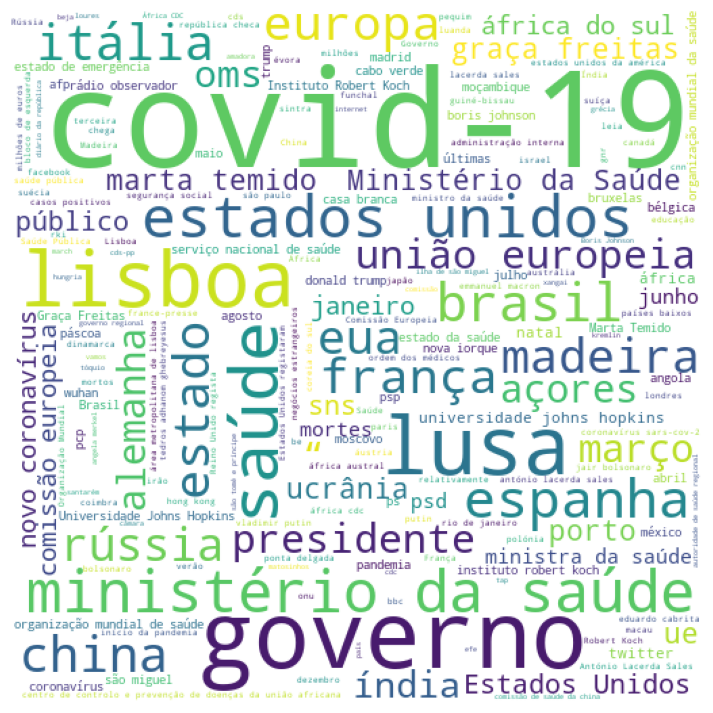

In [117]:
wordcloud = WordCloud(background_color='white', max_font_size=100, width=512, height=512).generate_from_frequencies(topic_freq_pt)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")

#### EN

### PT

In [ ]:
# Number of topics
num_topics_pt = len(topics_pt)
num_topics_pt_expanded = (sum(len(t) for t in topics_pt))

print('Number of topics in portuguese: ' + str(num_topics_pt) + ' (' + str(num_topics_pt_expanded) + ')')

#### Publico

In [ ]:
print('Publico first date:', df_publico_lb.iloc[-1].date)

In [ ]:
# Sentences Liveblog
num_sents_lb_publico = count_sents_inputDocs(inputDocs_publico)

avg_sents_topic_lb_publico = num_sents_lb_publico / num_topics_pt

print('Average sentences per topic in liveblog publico: ' + str(round(avg_sents_topic_lb_publico,2)))

# Dates Liveblog
num_dates_lb_publico = len(get_dates_list(inputDocs_publico))

avg_dates_topic_lb_publico = num_dates_lb_publico / num_topics_pt

print('Average dates per topic in liveblog publico: ' + str(round(avg_dates_topic_lb_publico,2)))

# Senteces/Dates Liveblog
avg_sentences_dates_lb_publico = avg_sents_topic_lb_publico/avg_dates_topic_lb_publico

print('Average senteces/dates per topic in liveblog publico: ' + str(round(avg_sentences_dates_lb_publico,2)))

In [ ]:
# Sentences Timeline
num_sents_tl_publico = count_sents_timelines(timelines_publico)

avg_sents_topic_tl_publico = num_sents_tl_publico / num_topics_pt

print('Average sentences per topic in timeline publico: ' + str(round(avg_sents_topic_tl_publico,2)))

# Dates Timeline
num_dates_tl_publico = len(get_dates_list(timelines_publico))

avg_dates_topic_tl_publico = num_dates_tl_publico / num_topics_pt

print('Average dates per topic in timeline publico: ' + str(round(avg_dates_topic_tl_publico,2)))

# Senteces/Dates Liveblog
avg_sentences_dates_tl_publico = avg_sents_topic_tl_publico/avg_dates_topic_tl_publico

print('Average senteces/dates per topic in timeline publico: ' + str(round(avg_sentences_dates_tl_publico,2)))

In [ ]:
# Compression Sents
compression_sents_publico = (avg_sents_topic_tl_publico/avg_sents_topic_lb_publico)*100

print('Compression of sentences publico: ' + str(round(compression_sents_publico,2)))

# Compression Dates
compression_dates_publico = (avg_dates_topic_tl_publico/avg_dates_topic_lb_publico)*100

print('Compression of dates publico: ' + str(round(compression_dates_publico,2)))

In [ ]:
# Number of input docs

n_inputDocs_publico = 0
for topic, date_news in inputDocs_publico.items():
  for date, news_list in date_news.items():
    n_inputDocs_publico += len(news_list)

print('Number of input docs in publico: ' + str(n_inputDocs_publico))

In [ ]:
# Number of timeline entries

n_timelines_publico = 0
for topic, date_news in timelines_publico.items():
  for date, news_list in date_news.items():
    n_timelines_publico += len(news_list)

print('Number of timeline entries in publico: ' + str(n_timelines_publico))

In [ ]:
stats_publico = {
    'n_topics': num_topics_pt,
    'lang': 'pt',
    'n_inputDocs': n_inputDocs_publico,
    'inputDocs_avg_sents': round(avg_sents_topic_lb_publico,2),
    'inputDocs_avg_dates': round(avg_dates_topic_lb_publico,2),
    'inputdocs_avg_sents_per_dates': round(avg_sentences_dates_lb_publico,2),
    'timeline_avg_sents': round(avg_sents_topic_tl_publico,2),
    'timeline_avg_dates': round(avg_dates_topic_tl_publico,2),
    'timeline_avg_sents_per_dates': round(avg_sentences_dates_tl_publico,2),
    'compression_sents': round(compression_sents_publico,2),
    'compression_dates': round(compression_dates_publico,2)
}

stats_dict['publico'] = stats_publico

#### Observador

In [ ]:
print('Observador first date:', df_observador_lb.iloc[-1].date)

In [ ]:
# Sentences Liveblog
num_sents_lb_observador = count_sents_inputDocs(inputDocs_observador)

avg_sents_topic_lb_observador = num_sents_lb_observador / num_topics_pt

print('Average sentences per topic in liveblog observador: ' + str(round(avg_sents_topic_lb_observador,2)))

# Dates Liveblog
num_dates_lb_observador = len(get_dates_list(inputDocs_observador))

avg_dates_topic_lb_observador = num_dates_lb_observador / num_topics_pt

print('Average dates per topic in liveblog observador: ' + str(round(avg_dates_topic_lb_observador,2)))

# Senteces/Dates Liveblog
avg_sentences_dates_lb_observador = avg_sents_topic_lb_observador/avg_dates_topic_lb_observador

print('Average senteces/dates per topic in liveblog observador: ' + str(round(avg_sentences_dates_lb_observador,2)))

In [ ]:
# Sentences Timeline
num_sents_tl_observador = count_sents_timelines(timelines_observador)

avg_sents_topic_tl_observador = num_sents_tl_observador / num_topics_pt

print('Average sentences per topic in timeline observador: ' + str(round(avg_sents_topic_tl_observador,2)))

# Dates Timeline
num_dates_tl_observador = len(get_dates_list(timelines_observador))

avg_dates_topic_tl_observador = num_dates_tl_observador / num_topics_pt

print('Average dates per topic in timeline observador: ' + str(round(avg_dates_topic_tl_observador,2)))

# Senteces/Dates Liveblog
avg_sentences_dates_tl_observador = avg_sents_topic_tl_observador/avg_dates_topic_tl_observador

print('Average senteces/dates per topic in timeline observador: ' + str(round(avg_sentences_dates_tl_observador,2)))

In [ ]:
# Compression Sents
compression_sents_observador = (avg_sents_topic_tl_observador/avg_sents_topic_lb_observador)*100

print('Compression of sentences observador: ' + str(round(compression_sents_observador,2)))

# Compression Dates
compression_dates_observador = (avg_dates_topic_tl_observador/avg_dates_topic_lb_observador)*100

print('Compression of dates observador: ' + str(round(compression_dates_observador,2)))

In [ ]:
# Number of input docs

n_inputDocs_observador = 0
for topic, date_news in inputDocs_observador.items():
  for date, news_list in date_news.items():
    n_inputDocs_observador += len(news_list)

print('Number of input docs in observador: ' + str(n_inputDocs_observador))

In [ ]:
# Number of timeline entries

n_timelines_observador = 0
for topic, date_news in timelines_observador.items():
  for date, news_list in date_news.items():
    n_timelines_observador += len(news_list)

print('Number of timeline entries in observador: ' + str(n_timelines_observador))

In [ ]:
stats_observador = {
    'n_topics': num_topics_pt,
    'lang': 'pt',
    'n_inputDocs': n_inputDocs_observador,
    'inputDocs_avg_sents': round(avg_sents_topic_lb_observador,2),
    'inputDocs_avg_dates': round(avg_dates_topic_lb_observador,2),
    'inputdocs_avg_sents_per_dates': round(avg_sentences_dates_lb_observador,2),
    'timeline_avg_sents': round(avg_sents_topic_tl_observador,2),
    'timeline_avg_dates': round(avg_dates_topic_tl_observador,2),
    'timeline_avg_sents_per_dates': round(avg_sentences_dates_tl_observador,2),
    'compression_sents': round(compression_sents_observador,2),
    'compression_dates': round(compression_dates_observador,2)
}

stats_dict['observador'] = stats_observador

#### Total

In [ ]:
print('Number of input docs in portuguese: ' + str(n_inputDocs_publico + n_inputDocs_observador))
print('Number of timelines in portuguese: ' + str(n_timelines_publico + n_timelines_observador))

### EN

#### CNN

#### Guardian

#### Total

### Export stats

In [ ]:
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index')
stats_df.to_excel("dataset_stats.xlsx")

In [ ]:
stats_df

### Timeline chart (**ToDo**)

In [ ]:
def gt_to_list(gt):
  news_list = []
  for _, n in gt.items():
    for d, l in n.items():
      for news in l:
        news_list.append((d, news))
  
  return news_list

In [ ]:
p_l = gt_to_list(gt_publico)
dfp = pd.DataFrame(p_l, columns=['date', 'news'])
dfp['source'] = 'publico'

In [ ]:
o_l = gt_to_list(gt_observador)
dfo = pd.DataFrame(o_l, columns=['date', 'news'])
dfo['source'] = 'observador'

In [ ]:
c_l = gt_to_list(gt_cnn)
dfc = pd.DataFrame(c_l, columns=['date', 'news'])
dfc['source'] = 'cnn'

In [ ]:
g_l = gt_to_list(gt_guardian)
dfg = pd.DataFrame(g_l, columns=['date', 'news'])
dfg['source'] = 'guardian'

In [ ]:
dfs = [dfp, dfo, dfc, dfg]

df_total = pd.concat(dfs)

In [ ]:
p_vc = dfp['date'].value_counts().rename_axis('dates').reset_index(name='counts')
p_vc['source'] = 'publico'

o_vc = dfo['date'].value_counts().rename_axis('dates').reset_index(name='counts')
o_vc['source'] = 'observador'

c_vc = dfc['date'].value_counts().rename_axis('dates').reset_index(name='counts')
c_vc['source'] = 'cnn'

g_vc = dfg['date'].value_counts().rename_axis('dates').reset_index(name='counts')
g_vc['source'] = 'guardian'

dfs_vc = [p_vc, o_vc, c_vc, g_vc]

df_vc_total = pd.concat(dfs_vc)

In [ ]:
df_vc_total = df_vc_total.sort_values(by='dates', ascending=False)

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#xxx = dfp['date'].value_counts().plot()
ax = sns.lineplot(x="dates", y="counts", hue='source', data=df_vc_total)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [ ]:
dfp = dfp.sort_values(by='date', ascending=True)

dfp['date'].value_counts().plot(rot=90);

In [ ]:
dfp

In [ ]:
dfo = dfo.sort_values(by='date', ascending=True)

dfo['date'].value_counts().plot(rot=90);

In [ ]:
dfo

In [ ]:
dfc = dfc.sort_values(by='date', ascending=True)

dfc['date'].value_counts().plot(rot=90);

In [ ]:
dfc

In [ ]:
dfg = dfg.sort_values(by='date', ascending=True)

dfg['date'].value_counts().plot(rot=90);

In [ ]:
dfg